In [1]:
import pandas as pd
import sklearn as sklearn
import numpy as np
import time
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lg
import optuna
import xgboost as xgb
import pickle
import os
import string 
import random
from datetime import date
import warnings
import threading
import shap

from typing import List, TypeVar, Dict, Callable
import abc

from sklearn.pipeline import Pipeline
from pandas.core.frame import DataFrame
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import precision_recall_curve

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer

from sklearn.svm import LinearSVR
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, roc_auc_score, precision_score, average_precision_score, roc_curve
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, accuracy_score, ConfusionMatrixDisplay
from sklearn import metrics

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from numpy import argmax
from swifter import swifter
from pandarallel import pandarallel


pd.options.mode.chained_assignment = None 
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
shap.initjs()

0) use predictproba instead of predict +
1) fix train set +
2) calculate threshold (precision, recall, f1) +
3) probability distribution
4) Lecture 6.1, 6.0.1
5) SHAP
6) Exploratory analysis
7) Feature engineering +-

====

15 - 400
23 - 150
50 - 0.895

=====


In [2]:
_СORRELATION_MATRIX_PATH_ = 'corr_matrix.pcl'
_СHURN_PATH_ = 'churn_model.pcl'
_CHURN_PATH_REDUCED_ = 'churn_model_reduced.pcl' 

In [3]:
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 2 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [4]:
# https://towardsdatascience.com/interpreting-roc-curve-and-roc-auc-for-classification-evaluation-28ec3983f077
# https://neptune.ai/blog/f1-score-accuracy-roc-auc-pr-auc
# https://www.statology.org/plot-roc-curve-python/
# https://analyticsindiamag.com/complete-guide-to-lightgbm-boosting-algorithm-in-python/
# https://cosmiccoding.com.au/tutorials/pr_vs_roc_curves/#:~:text=The%20important%20difference%20to%20note,the%20other%20on%20the%20estimate.

class Metrics:
    
    def roc_auc(y_true, predicted):
        return roc_auc_score(y_true, predicted)
    
    def plot_precision_recall(y_true:list, predicted:list, labels:list):

        for i in range(0, len(y_true)):
            precision, recall, thresholds = metrics.precision_recall_curve(y_true[i], predicted[i])
            plt.plot(recall, precision, label=labels[i])

        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.legend(loc=3)
        plt.show()

    def plot_auc(y_true:list, predicted:list, labels:list):
        
        for i in range(0, len(y_true)):
            fpr, tpr, thresholds = metrics.roc_curve(y_true[i], predicted[i])
            auc = round(metrics.roc_auc_score(y_true[i], predicted[i]),3)
            plt.plot(fpr,tpr, label=f"{labels[i]} AUC="+str(auc))

        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.legend(loc=4)
        plt.show()
    
    def XY_plot(Xs:list, Ys:list, legends:list, x_label:str, y_label:str):
        
        for i in range(0, len(Xs)):      
            plt.plot(Xs[i], Ys[i], label=legends[i])
        
        plt.ylabel(y_label)
        plt.xlabel(x_label)
        plt.legend(loc=1)
        plt.show()
    
    def BAR_plot(X, Y, title:str, x_label:str, y_label:str, width=10, height=5):
        fig = plt.figure(figsize = (width, height))
        plt.bar(X, Y, color ='maroon', width = 0.4)
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.title(title)
        plt.show()
    
    def plot_probability_distribution(y_true, predicted):
    
        data = list(zip(predicted, y_true))

        X_0 = [e[0] for e in data if e[1] == 0]
        X_1 = [e[0] for e in data if e[1] == 1]

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

        ax1.hist(X_0, label='Non-churned', bins=200, alpha=0.5, color='grey')
        ax1.set_xlabel('Probability')
        ax1.set_ylabel('Number of clients')
        ax1.legend()
        
        ax2.hist(X_1, label='Churned', bins=200, alpha=0.5, color='orange')
        ax2.set_xlabel('Probability')
        ax2.set_ylabel('Number of clients')
        ax2.legend()

        plt.show()
    
    def classification_report(y_true, predicted):
        return classification_report(y_true, predicted)
    
    def confusion_matrix(y_true, predicted):
        return confusion_matrix(y_true, predicted)

In [5]:
def get_random_string(length):
    letters = string.ascii_lowercase
    result_str = ''.join(random.choice(letters) for i in range(length))
    return result_str

In [6]:
def get_float_cols(df:DataFrame) -> List[str]:
    return df.select_dtypes(include=float).columns.tolist()

def get_int_cols(df:DataFrame) -> List[str]:
    return df.select_dtypes(include=int).columns.tolist()

def get_number_cols(df:DataFrame) -> List[str]:
    return df.select_dtypes(np.number).columns.tolist()

def get_obj_cols(df:DataFrame) -> List[str]:
    return list(df.select_dtypes(include=object).columns)
    
def get_empty_cols(df:DataFrame):
    return list(df.isnull().sum()[lambda x: x > 0].index)

In [7]:
def reduce_mem_usage(df, verbose=True) -> pd.DataFrame:
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2  
    
    for col in df.columns:
        
        # skip
        if (col in ['Application', 'abon_id']):
            continue
        
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [8]:
def split_test_train(df:DataFrame):
    test, train = df[df['ind'].eq('test')], df[df['ind'].eq('train')]
    test = test.drop(['ind'], axis=1)
    train = train.drop(['ind'], axis=1)
    return test, train
    
def combine_test_train(test:DataFrame, train:DataFrame):
    combine = pd.concat([test.assign(ind='test'), train.assign(ind='train')])
    target = train['target']
    test_ids = test['Id']
    return combine, target, test_ids

def combine_data(train_df, train_num, train_dpi, test_df, test_num, test_dpi):
    df_combine = pd.concat([train_df.assign(ind='train'), test_df.assign(ind='test')])
    df_combine_num = pd.concat([train_num.assign(ind='train'), test_num.assign(ind='test')])
    df_combine_dpi = pd.concat([train_dpi.assign(ind='train'), test_dpi.assign(ind='test')])
    return df_combine, df_combine_num, df_combine_dpi

## Data size reduction

In [9]:
def reduce_churn_data():

    if os.path.exists(_CHURN_PATH_REDUCED_) == False:
        if os.path.exists(_СHURN_PATH_) == True: 
    
            with open(_СHURN_PATH_, 'rb') as file:
                deserialized_object = pickle.load(file)

            deserialized_object = list(deserialized_object)
        
            # reduce size
            train_df= reduce_mem_usage(deserialized_object[1][1])
            train_num_reduced = reduce_mem_usage(deserialized_object[1][2])
            train_dpi_reduced = reduce_mem_usage(deserialized_object[1][3])

            test_df = reduce_mem_usage(deserialized_object[2][1])
            test_num_reduced = reduce_mem_usage(deserialized_object[2][2])
            test_dpi_reduced = reduce_mem_usage(deserialized_object[2][3])
            
            # dump data back
            deserialized_object = tuple([[train_df, train_num_reduced, train_dpi_reduced], [test_df, test_num_reduced, test_dpi_reduced]])
            pickle.dump(deserialized_object, open(_CHURN_PATH_REDUCED_, 'wb'))
    else:
        print(f'{_CHURN_PATH_REDUCED_} already exist')

In [10]:
def load_churn_data():

    with open(_СHURN_PATH_, 'rb') as file:
        deserialized_object = pickle.load(file)

    train_df = deserialized_object[1][1]
    train_num = deserialized_object[1][2]
    train_dpi = deserialized_object[1][3]

    test_df = deserialized_object[2][1]
    test_num = deserialized_object[2][2]
    test_dpi = deserialized_object[2][3]

    return train_df, train_num, train_dpi, test_df, test_num, test_dpi

In [11]:
def load_churn_reduced():

    with open(_CHURN_PATH_REDUCED_, 'rb') as file:
        deserialized_object = pickle.load(file)

    train_df = deserialized_object[0][0]
    train_num = deserialized_object[0][1]
    train_dpi = deserialized_object[0][2]

    test_df = deserialized_object[1][0]
    test_num = deserialized_object[1][1]
    test_dpi = deserialized_object[1][2]

    return train_df, train_num, train_dpi, test_df, test_num, test_dpi

In [12]:
class TelephoneHelper:
    
    def is_short_number(number:str) -> bool:
        if (number.isdigit() and len(number) <= 4):
            return True
        return False

    def is_life(number:str) -> bool:
        if (len(number) == 12 and (number[2:5] in [b'063', b'093', b'073' ])):
            return True
        return False

    def is_kyivstar(number:str) -> bool:
        if (len(number) == 12 and (number[2:5] in [b'067', b'097', b'068', b'098', b'098'])):
            return True
        return False
    
    def is_vodafone(number:str) -> bool:
        if (len(number) == 12 and (number[2:5] in [b'050', b'095', b'099', b'066' ])):
            return True
        return False
    
    def is_non_vodafone(number:str) -> bool:
        if (len(number) == 12 and not TelephoneHelper.is_vodafone(number)):
            return True
        return False
    
    def is_string_number(number:str) -> bool:
        if (number.isdigit() == False):
            return True
        return False

### Feature selectors

In [13]:
class FeatureHelper:
    
    def get_feature_correlation_df(corr_m, remove_duplicates=True, remove_self_correlations=True):
    
        corr_matrix_abs = corr_m.abs()
        corr_matrix_abs_us = corr_matrix_abs.unstack()
        sorted_correlated_features = corr_matrix_abs_us \
            .sort_values(kind="quicksort", ascending=False) \
            .reset_index()

        # Remove comparisons of the same feature
        if remove_self_correlations:
            sorted_correlated_features = sorted_correlated_features[
                (sorted_correlated_features.level_0 != sorted_correlated_features.level_1)
            ]

        # Remove duplicates
        if remove_duplicates:
            sorted_correlated_features = sorted_correlated_features.iloc[:-2:2]

        # Create meaningful names for the columns
        sorted_correlated_features.columns = ['f1', 'f2', 'corr']

        return sorted_correlated_features
    
    def get_correlation_matrix(df:DataFrame, method:str, save_path:str):
        if os.path.exists(save_path) == False:
            corr_matrix = df.corr(method = method, numeric_only = True)
            pickle.dump(corr_matrix, open(save_path, 'wb'))
        else:
            corr_matrix = pickle.load(open(save_path, 'rb'))

        return corr_matrix

    def remove_aggr_function(str_to_check:str) -> str:
        parts = str_to_check.split('_')
        
        if (len(parts) > 2):
            index_to_remove = len(parts) - 2
            
            # remove aggregation function
            if (parts[index_to_remove] in ['min', 'std', 'max', 'mea', 'td']):
                parts.remove(parts[index_to_remove])
                
            result = '_'.join(parts)
            return result
        else:
            return str_to_check    

        
    def get_heatmap_matrix(corr_matrix:DataFrame):
        heatmap_matrix = pd.DataFrame(corr_matrix['target'].abs())
        heatmap_matrix = heatmap_matrix.sort_values(by='target', ascending=False)
        heatmap_matrix = heatmap_matrix.drop(index=['target'])           
        return heatmap_matrix
    
    # index - column name
    # target - value
    def plot_heatmap(heatmap_matrix:DataFrame):
        plt.figure(figsize=(40, 120))
        heatmap = sns.heatmap(heatmap_matrix, vmin=-1, vmax=1, annot=True, cmap='BrBG')
        heatmap.set_title('Features Correlating with Churn Rate', fontdict={'fontsize':18}, pad=16);
        return heatmap_matrix
    
    def get_important_features(heatmap_matrix:DataFrame, use_groupping = False, num_of_features:int = -1):
        df_features = heatmap_matrix.reset_index()
        df_features = df_features.rename(columns = {'index':'feature'})
        
        # apply aggregation function for further groupping
        df_features['feature_group'] = df_features['feature'].apply(FeatureHelper.remove_aggr_function)
        df_features = df_features[['feature', 'feature_group', 'target']]
        sorted_features = df_features.sort_values(by=['feature_group', 'target'], ascending = [False, False])
        
        # take first item from the group
        if (use_groupping == True):
            important_features = sorted_features.groupby('feature_group').first()
        else:
            important_features = sorted_features

        # order by target
        important_features = important_features.sort_values(by='target', ascending=False)
           
        # take N first rows
        if (num_of_features != -1):
            important_features = important_features.head(num_of_features)
        
        # optimize for heatmap
        important_features = important_features.reset_index()
        important_features = important_features[['feature', 'target']]
        important_features.index = important_features['feature']
        important_features.index.name = None
        important_features = important_features[['target']]
        important_features = important_features[important_features['target'] > 0]
        
        return important_features
    
    def get_important_features_tuples(heatmap_matrix:DataFrame, num_of_features:int = -1):
        important_features = FeatureHelper.get_important_features(heatmap_matrix, num_of_features)
        
        if (num_of_features == -1):
            num_of_features = len(important_features)
        
        important_features_tuples = list(zip(important_features.index, 
                                             important_features.target, 
                                             list(range(0, num_of_features))))
        
        return important_features_tuples

In [14]:
class FeatureSelector(abc.ABC):

    @abc.abstractmethod
    def get_heatmap(self) -> pd.DataFrame:
        pass

    @abc.abstractmethod
    # index - feature name, target
    def get_important_features(self) -> pd.DataFrame:
        pass
    
    @abc.abstractmethod
    # 1 - feature name, 2 - target, 3 - sorted number
    def get_important_features_tuples(self) -> List[tuple[str, float, int]]:
        pass

In [15]:
class CorrelationSelector(FeatureSelector):
    
    def __init__(self, data:pd.DataFrame, corr_method:str, num_of_features:int):
        self.data = data
        self.corr_method = corr_method
        self.file_prefix = corr_method
        self.num_of_features = num_of_features
        self.get_heatmap()
    
    def get_heatmap(self) -> pd.DataFrame:
        self.save_path = f'{self.file_prefix}_{_СORRELATION_MATRIX_PATH_}'
        self.corr_m = FeatureHelper.get_correlation_matrix(self.data, self.corr_method, self.save_path)
        self.heatmap_m = FeatureHelper.get_heatmap_matrix(self.corr_m)
        return self.heatmap_m 
    
    def get_important_features(self) -> pd.DataFrame:
        return FeatureHelper.get_important_features(self.heatmap_m, self.num_of_features)
    
    def plot_heatmap(self):
        FeatureHelper.plot_heatmap(self.get_important_features())
    
    def get_non_correlated_features(self, barrier_coef:float, do_log:bool) -> List[str]:
        
        important_tuples = FeatureHelper.get_important_features_tuples(self.heatmap_m, self.num_of_features)
        # f1, f2, corr
        features_corr = FeatureHelper.get_feature_correlation_df(self.corr_m)
        
        already_processed = set()
        all_features = [t[0] for t in important_tuples]

        for f in all_features:
            # get correlated features
            correlated = list(features_corr[(features_corr['f1']==f) & (features_corr['corr'] > barrier_coef)]['f2'])

            # if highly correlated features exist
            if (len(correlated)>0):

                for to_remove in correlated:
                    if (to_remove not in already_processed):
                        if (to_remove in all_features):
                            all_features.remove(to_remove)
                            if do_log: print(f'Removing: {to_remove} for {f}')            

        # remember initial feature
        already_processed.add(f)
        
        # return non-correlated features
        return all_features
    
    def get_important_noncorrelated_features_tuples(self, mutual_correlation:float, feature_importance:float):
        
        final = []
        important = self.get_important_features_tuples()
        non_correlated = self.get_non_correlated_features(mutual_correlation, False)
        
        for i in important:
            if (i[0] in non_correlated and i[1] > feature_importance):
                final.append(i)

        return final
                        
    def get_important_features_tuples(self) ->  List[tuple[str, float, int]]:
        return FeatureHelper.get_important_features_tuples(self.heatmap_m, self.num_of_features)
    
    def __str__(self):
        return type(self).__name__ + '_' + self.corr_method

In [16]:
# https://nitin9809.medium.com/lightgbm-binary-classification-multi-class-classification-regression-using-python-4f22032b36a2
# https://www.analyticsvidhya.com/blog/2020/10/feature-selection-techniques-in-machine-learning/
class LGBMSelector(FeatureSelector):
    
    heatmap_calculated = False
    
    def __init__(self,
                 data:pd.DataFrame,
                 num_of_features:int,
                 model_params = None,
                 model_file = '___LGBMSelector_simple.pcl'):
        
        self.model_file = model_file
        self.data = data
        self.num_of_features = num_of_features
        self.model_params = model_params
        self.train_model()
    
    def train_model(self):
        test, train = split_test_train(self.data)

        self.y_train = train['target'].round(0).astype(int)
        self.y_test = test['target'].round(0).astype(int)

        self.x_train = train.drop(['target'], axis=1)
        self.x_test = test.drop(['target'], axis=1)
        
        # regressor
        if os.path.exists(self.model_file) == True: 
            with open(self.model_file, 'rb') as file:
                self.regressor = pickle.load(file)
        else:       
            if (self.model_params is not None):
                self.regressor = lg.LGBMClassifier(**self.model_params)
            else:
                self.regressor = lg.LGBMClassifier()
    
            self.regressor.fit(self.x_train, self.y_train)
        
        # predict
        self.test_predicted = self.regressor.predict_proba(self.x_test)[:,1]
        self.train_predicted = self.regressor.predict_proba(self.x_train)[:,1]
        
        #save model
        pickle.dump(self.regressor, open(self.model_file, 'wb'))
    
    def get_feature_importance_raw(self):
        return self.regressor.feature_importances_
    
    def get_heatmap(self) -> pd.DataFrame:
        df_feature_importance = pd.DataFrame(list(zip(list(self.get_feature_importance_raw()), list(self.data.columns))))
        df_feature_importance = df_feature_importance.set_axis(['target', 'feature'], axis=1)
        df_feature_importance = df_feature_importance.sort_values(by=['target'], ascending=False)
        df_feature_importance = df_feature_importance.set_index('feature')
        df_feature_importance.index.name = None
        self.heatmap_m = df_feature_importance
        self.heatmap_calculated = True
        return self.heatmap_m
    
    def plot_heatmap(self):
        FeatureHelper.plot_heatmap(self.get_important_features())

    def get_important_features(self) -> pd.DataFrame:
        if (self.heatmap_calculated == False):
            self.get_heatmap()
            
        return FeatureHelper.get_important_features(self.heatmap_m, self.num_of_features)
    
    def get_important_features_tuples(self) -> List[tuple[str, float, int]]:
        if (self.heatmap_calculated == False):
            self.get_heatmap()
            
        features_tuples = FeatureHelper.get_important_features_tuples(self.heatmap_m, self.num_of_features)
        return features_tuples
        
    def get_test_ROCAUC(self):
        return Metrics.roc_auc(self.y_test, self.test_predicted)

    def get_train_ROCAUC(self):
        return Metrics.roc_auc(self.y_train, self.train_predicted)

    def __str__(self):
        return type(self).__name__

In [17]:
# https://neptune.ai/blog/lightgbm-parameters-guide
class EnhancedLGBMSelector(LGBMSelector):
    
    def __init__(self, data, model_file_name:str = '___EnhancedLGBMSelector_model_800_features.pcl'):
        self.model_file = model_file_name
        super().__init__(data, -1, None, model_file_name)
    
    def get_feature_importance_raw(self):
        return self.regressor.feature_importance()
    
    def train_model(self):        
        
        test, train = split_test_train(self.data)

        self.y_train = train['target'].round(0).astype(int)
        self.y_test = test['target'].round(0).astype(int)

        self.x_train = train.drop(['target'], axis=1)
        self.x_test = test.drop(['target'], axis=1)

        X_train_final, X_test_validation, y_train_final, y_test_validation = train_test_split(self.x_train, 
                                                                                              self.y_train, 
                                                                                              stratify=self.y_train,
                                                                                              test_size=0.25)
        
        # save for SHAP
        self.X_validation = X_test_validation
        
        # Specifying datasets
        d_train = lg.Dataset(X_train_final, label=y_train_final)
        d_test = lg.Dataset(X_test_validation, label=y_test_validation, reference=d_train)

        # load model from disk
        if os.path.exists(self.model_file) == True: 
            with open(self.model_file, 'rb') as file:
                self.regressor = pickle.load(file)
        # Train model
        else:
            params={}
            params['boosting_type']='dart' 
            params['objective']='binary' 
            params['metric']='auc' 
            params['verbosity'] = 2
            params['is_unbalance'] = True

            #train the model 
            self.regressor=lg.train(params = params, 
                                    train_set = d_train,
                                    valid_sets = d_test, 
                                    num_boost_round = 400, 
                                    callbacks= [lg.early_stopping(stopping_rounds=20)])
        
        # make prediction     
        self.test_predicted = self.regressor.predict(self.x_test)
        self.train_predicted = self.regressor.predict(self.x_train)
        
        #save model
        if os.path.exists(self.model_file) == False:
            print(f'Saving model to file {self.model_file}. Data shape: {self.data.shape}. Train ROCAUC: {self.get_train_ROCAUC()}. Test ROCAUC: {self.get_test_ROCAUC()}')
            pickle.dump(self.regressor, open(self.model_file, 'wb'))


In [18]:
class IterativeLGBMSelector(FeatureSelector):
    
    results_file = 'IterativeLGBMSelector_results.pcl'
    model_file = 'IterativeLGBMSelector_model.pcl'
    df_file = 'IterativeLGBMSelector_df.pcl'
    
    def __init__(self, 
                 data:pd.DataFrame, 
                 selector:EnhancedLGBMSelector,
                 base_line_auc:float,
                 num_of_boosting_rounds:int,
                 do_log:bool):
        
        self.results_file = f'___{base_line_auc}_{num_of_boosting_rounds}_{self.results_file}'
        self.model_file = f'___{base_line_auc}_{num_of_boosting_rounds}_{self.model_file}'
        self.df_file =  f'___{base_line_auc}_{num_of_boosting_rounds}_{self.df_file}'
        
        self.data = data
        self.trained_selector = selector
        self.base_line_auc = base_line_auc
        self.num_of_boosting_rounds = num_of_boosting_rounds
        self.do_log = do_log
        
        # check pre-saved results
        if os.path.exists(self.results_file) == True:
            
            with open(self.results_file, 'rb') as file:
                self.result = pickle.load(file)
            
            with open(self.model_file, 'rb') as file:
                self.regressor = pickle.load(file)
                
            with open(self.df_file, 'rb') as file:
                self.df = pickle.load(file)
            
            # save data for metrics
            test, train = split_test_train(self.df)
            self.y_train = train['target'].round(0).astype(int)
            self.y_test = test['target'].round(0).astype(int)
            self.x_train = train.drop(['target'], axis=1)
            self.x_test = test.drop(['target'], axis=1)
            
            # predict
            self.train_predicted = self.regressor.predict(self.x_train)
            self.test_predicted = self.regressor.predict(self.x_test)
            
        else:
            self.result = self.train_model()
    
    def get_regressor(self):
        return self.regressor
    
    def get_training_results(self):
        return self.result
    
    def train_model(self):
        
        all_features = [f[0] for f in self.trained_selector.get_important_features_tuples()]
        do_log = True
        existing = ['target', 'ind']
        roc_auc = 0
        prev_roc_auc = 0
        increase_rate = 0
        result = []

        # for every column
        for c in list(all_features):
            if c != 'target':

                # add column
                existing.append(c)

                # new dataset
                df = df_combine[existing]

                # build model
                test, train = split_test_train(df)
                y_train = train['target'].round(0).astype(int)
                y_test = test['target'].round(0).astype(int)
                x_train = train.drop(['target'], axis=1)
                x_test = test.drop(['target'], axis=1)

                # split train on train and validation
                X_train_final, X_test_validation, y_train_final, y_test_validation = train_test_split(x_train, 
                                                                                                      y_train, 
                                                                                                      stratify=y_train,
                                                                                                      test_size=0.25)
        
                # create datasets
                d_train = lg.Dataset(X_train_final, label=y_train_final)
                d_test = lg.Dataset(X_test_validation, label=y_test_validation, reference=d_train)

                params={}
                params['boosting_type']='dart' 
                params['objective']='binary' 
                params['metric']='auc' 
                params['verbosity'] = 0

                # train the model 
                regressor=lg.train(params = params, 
                              train_set = d_train,
                              valid_sets = d_test, 
                              num_boost_round = self.num_of_boosting_rounds)

                # calculate metric
                predicted = regressor.predict(x_train)

                try:
                    roc_auc = Metrics.roc_auc(y_train, predicted)
                except ValueError:
                    roc_auc = -1

                # save result
                diff = roc_auc - prev_roc_auc
                item = (len(existing), existing, roc_auc, diff)
                result.append(item)
                if self.do_log == True: print(f'======== {len(existing)} -> AUC: {roc_auc} -> DIFF: {diff}' )

                if (roc_auc > self.base_line_auc):
                    if self.do_log == True: print(f'======== {roc_auc} increased base line threshold with {len(existing) -2} features {existing}')
                    break

                # handle negative impact
                if (diff < -0.01):
                    if self.do_log == True: print(f'======== Feature {c} gives negative impact of {diff}. Removing it.')
                    existing.remove(c)
                else:
                    prev_roc_auc = roc_auc
        
        # save result to file
        pickle.dump(result, open(self.results_file, 'wb'))
        pickle.dump(regressor, open(self.model_file, 'wb'))
        pickle.dump(df, open(self.df_file, 'wb'))
        self.regressor = regressor
        
        # make prediction
        self.train_predicted = self.regressor.predict(x_train)
        self.test_predicted = self.regressor.predict(x_test)
        
        # data for metrics calc
        self.y_train = y_train
        self.y_test  = y_test 
        self.x_train = x_train
        self.x_test  = x_test 
        
        return result
    
    def get_heatmap(self) -> pd.DataFrame:
        pass
    
    def plot_heatmap(self):
        pass
    
    def get_important_features(self) -> pd.DataFrame:
        return self.result[-1][1][2:]
    
    def get_important_features_tuples(self) -> List[tuple[str, float, int]]:
        return self.result[-1][1][2:]
    
    def get_test_ROCAUC(self):
        return Metrics.roc_auc(self.y_test, self.test_predicted)

    def get_train_ROCAUC(self):
        return Metrics.roc_auc(self.y_train, self.train_predicted)

## Data Transformation

In [19]:
class TransformPipe:
    
    def __init__(self, funcs:List[Callable], **kwargs):
        self.funcs = funcs
        self.kwargs = kwargs
    
    def transform(self, df:DataFrame) -> DataFrame:
        for f in self.funcs:
            df = f(df, **self.kwargs)
            
        return df

In [20]:
# kwargs -> col_names_to_impute, verbose, impute_method
def impute_numeric_cols(df:DataFrame, **kwargs) -> DataFrame:
    
    impute_method = kwargs['impute_method']
    
    col_names = kwargs['col_names_to_impute']
    
    # all possible columns
    initial_cols = list(df.columns)
    
    for col_name in col_names:

        non_empty_numeric =  (set(get_number_cols(df)) - set(get_empty_cols(df))) | {col_name}        
        cols_names_to_drop = list((set(df.columns) - non_empty_numeric))
        
        if (kwargs['verbose']==True): print('Deleting: {0}. Imputing: {1}'.format(cols_names_to_drop, col_name))
        
        # save temp
        temp = df[cols_names_to_drop]

        # clear dataset 
        df = df.drop(columns=cols_names_to_drop)
        
        known = df.loc[ df[col_name].notnull() ]        
        unknown = df.loc[ df[col_name].isnull() ]
        
        # nothing to predict
        if (len(unknown) == 0): 
            if (kwargs['verbose']==True): print('Nothing to predict - continue')
            continue
        
        column_index = list(df.columns).index(col_name)

        all_indices = [i for i in range(unknown.shape[1])]
        diff = list(set(all_indices) - {column_index})

        y = known.values[:, column_index]
        X = known.values[:, diff]

        # select regressor
        if impute_method == 'randomforest':
            regressor = RandomForestRegressor(n_estimators=100, n_jobs=-1)
        if impute_method == 'knn':
            regressor = KNeighborsRegressor()
            
        regressor.fit(X, y)
        predicted = regressor.predict(unknown.values[:, diff])
        
        if (kwargs['verbose']==True): print('{0} was predicted. Len: {1}'.format(col_name, len(predicted)))
        
        # fill missings
        df.loc[ (df[col_name].isnull()), col_name ] = predicted
        
        # restore dataset
        df[cols_names_to_drop] = temp
    
    # reorder columns back
    df = df.reindex(columns = initial_cols)
    
    return df

In [21]:
def remove_skew(df:DataFrame, **kwargs) -> DataFrame:
    
    excluded_features = kwargs['excluded_features']
    
    skew_df = pd.DataFrame(get_number_cols(df), columns=['Feature'])
    skew_df['Skew'] = skew_df['Feature'].apply(lambda feature: scipy.stats.skew(df[feature]))
    skew_df['Absolute Skew'] = skew_df['Skew'].apply(abs)
    skew_df['Skewed'] = skew_df['Absolute Skew'].apply(lambda x: True if x >= 0.5 else False)

    for column in skew_df.query("Skewed == True")['Feature'].values:
        if (column not in excluded_features):
            df[column] = np.log1p(df[column])
        else:
            print(f'Skipping column: {column}')
            
    return df

### Threshold selectors

In [22]:
class ThresholdHelper:
    
    def apply_binary_threshold(threshold:float, y_predicted):
        result = []

        for y in y_predicted:
            if (y >= threshold):
                result.append(1)
            else:
                result.append(0)

        return result

In [23]:
class ThresholdSelector(abc.ABC):

    @abc.abstractmethod
    def get_threshold(self, y_true, y_predicted) -> float:
        pass

In [24]:
class F1ThresholdSelector(ThresholdSelector):
    
    def get_f1(self, y_real, y_predicted) -> float:
        precision, recall, thresholds = precision_recall_curve(y_real, y_predicted)
        fscore = (2 * precision * recall) / (precision + recall)
        ix = argmax(fscore)
        f_score = fscore[ix]
        return f_score
    
    def get_threshold(self, y_real, y_predicted) -> float:
        precision, recall, thresholds = precision_recall_curve(y_real, y_predicted)
        fscore = (2 * precision * recall) / (precision + recall)
        ix = argmax(fscore)
        best_threshold = thresholds[ix]
        return best_threshold
    

In [25]:
class PriceBasedThresholdSelector(ThresholdSelector):
    
    def __init__(self, add_new_abon_price:float, retain_abon_price:float, plot:bool):
        self.plot = plot
        self.add_new_abon_price = add_new_abon_price
        self.retain_abon_price = retain_abon_price
        self.plot 
    
    def price_for_threshold(self, threshold) -> float:
        ix = self.X.index(threshold)
        return self.Y[ix]
    
    def get_threshold(self, y_real, y_predicted) -> float:
        
        X = []
        TNs = []
        FNs = []
        TPs = []
        FPs = []
        Y = []
        
        for thr in np.arange (0, 1, 0.01):
            test_predicted_final = ThresholdHelper.apply_binary_threshold(thr, y_predicted)
            conf_m = Metrics.confusion_matrix(y_real, test_predicted_final)

            TN = conf_m[0][0] 
            FN = conf_m[1][0]
            TP = conf_m[1][1]
            FP = conf_m[0][1]

            final_price = TP*self.retain_abon_price + FP*self.retain_abon_price + FN*self.add_new_abon_price

            X.append(thr)            
            TNs.append(TN)
            FNs.append(FN)
            TPs.append(TP)
            FPs.append(FP)
            Y.append(final_price)
            
        best_threshold = X[Y.index(min(Y))]        
        f1_selector = F1ThresholdSelector()
        f1_threshold = f1_selector.get_threshold(y_real, y_predicted)
        
        if self.plot == True:
                    
            threshold_price_X = [best_threshold, best_threshold]
            threshold_price_Y = [0, max([*TPs, *FPs, *FNs])]
            
            threshold_f1_X = [f1_threshold, f1_threshold]
            threshold_f1_Y = [0, max([*TPs, *FPs, *FNs])]
            
            # price
            Metrics.XY_plot([X, threshold_f1_X, threshold_price_X],
                            [Y, [0, max(Y)], [0, max(Y)]], 
                            ['Price', 'F1 threshold', 'Price threshold'],
                            'threshold', 'price')

            # metrics
            Metrics.XY_plot([X, X, X, threshold_f1_X, threshold_price_X ],
                            [TPs, FPs, FNs, threshold_f1_Y, threshold_price_Y ],
                            ['TPs', 'FPs', 'FNs', 'F1 threshold', 'Price threshold'], 
                            'threshold', 'metrics')

        self.X = X
        self.Y = Y
        self.best_threshold = best_threshold
        
        return best_threshold

### Full experiment

In [26]:
class Experiment:
    
    def __init__(self, 
                data:DataFrame,
                selector:FeatureSelector, 
                transformer:TransformPipe):
        self.data = data
        self.selector = selector
        self.transformer = transformer
        
    def run(self):
        pass

## Load Data

In [27]:
train_df, train_num, train_dpi, test_df, test_num, test_dpi = load_churn_reduced()
df_combine, df_combine_num, df_combine_dpi = combine_data(train_df, train_num, train_dpi, test_df, test_num, test_dpi)

### Main Data Anaysis

In [28]:
empty_cols = set(get_empty_cols(df_combine))
all_cols = set(df_combine.columns)
non_empty = all_cols - empty_cols

In [29]:
res = []

for percent in np.arange(0.1, 1, 0.1):
    res.append(len([i for i in df_combine.columns if df_combine[i].isnull().sum() > percent*len(df_combine)]))
    
print(res)

[107, 105, 84, 80, 63, 63, 62, 62, 48]


In [30]:
X = [str(int(100*v)) + '%' for v in np.arange(0.1, 1, 0.1)]

In [31]:
Y = res

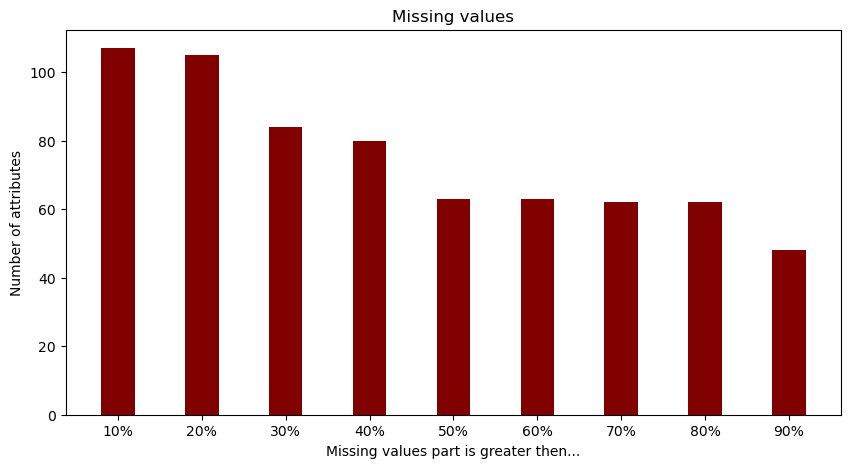

In [46]:
Metrics.BAR_plot(X, Y, 'Missing values', 'Missing values part is greater then...', 'Number of attributes')

### Telephone nums analysis

In [53]:
df_combine_num.shape

(1340788, 9)

In [54]:
test_unique = len(df_combine_num[df_combine_num['ind'] == 'test']['abon_id'].unique())
test_percent = round((test_unique/150000)*100, 0)

In [55]:
train_unique = len(df_combine_num[df_combine_num['ind'] == 'train']['abon_id'].unique())
train_percent = round((train_unique/150000)*100, 0)

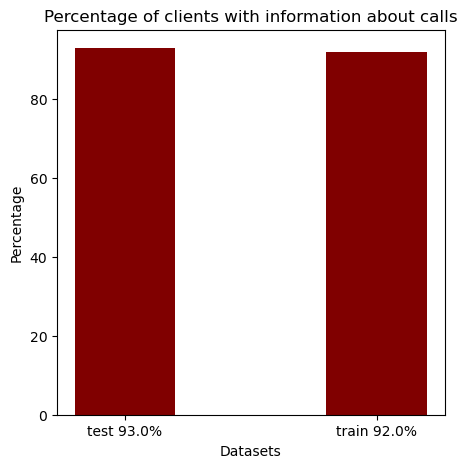

In [63]:
Metrics.BAR_plot([f'test {test_percent}%', f'train {train_percent}%'], 
                 [test_percent, train_percent], 
                 'Percentage of clients with information about calls',
                 'Datasets',
                 'Percentage',
                 5, 5)

In [68]:
final = df_combine_num.groupby('abon_id').count()[['bnum']]

In [80]:
average_nums_per_abon = round(final['bnum'].sum()/(train_unique+test_unique),2)

In [81]:
print(f'Average num per abon: {average_nums_per_abon}')

Average num per abon: 4.83


In [82]:
train_unique+test_unique

277576

### Applications analysis

In [84]:
test_unique = len(df_combine_dpi[df_combine_dpi['ind'] == 'test']['abon_id'].unique())
test_percent = round((test_unique/150000)*100, 0)

In [85]:
train_unique = len(df_combine_dpi[df_combine_dpi['ind'] == 'train']['abon_id'].unique())
train_percent = round((train_unique/150000)*100, 0)

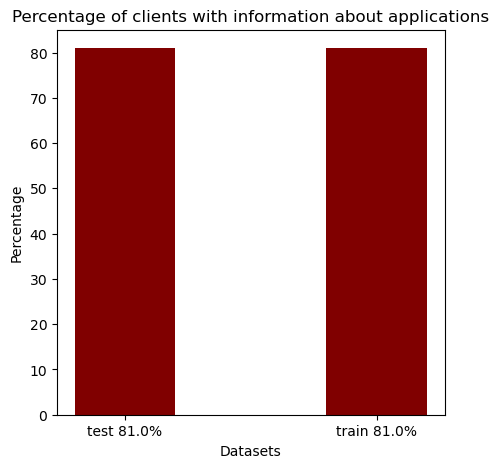

In [86]:
Metrics.BAR_plot([f'test {test_percent}%', f'train {train_percent}%'], 
                 [test_percent, train_percent], 
                 'Percentage of clients with information about applications',
                 'Datasets',
                 'Percentage',
                 5, 5)

In [52]:
df_combine[df_combine['BS_OVERBUNDLE_MB_CNT_M1'].isna()]

,Ama_rchrgmnt_sum_max_mnt1,content_clc_mea_mnt1,content_cnt_max_mnt1,voice_out_short_part_max_mnt1,voice_mts_in_nrest_part_std_mnt1,num_act_days_max_mnt1,sms_roam_clc_min_mnt1,voice_in_cmpttrs_avg_durmin_mnt1,com_num_part_mea_mnt1,pay_avg_mea_mnt1,...,MV_DOU_OT,MV_SERV_Y_WO_AF,MV_Migr_To,MV_SERV_RLH,MV_DOU_PPM_VF,MV_DOU_Neg_Bal,MV_ot_total,target,abon_id,ind
0,0,0.0,13.843750,1.480469,0.000000,5.324219,0,19.046875,1.657227,0.000000,...,1.480469,NaN,0.0,NaN,13.007812,NaN,0.0,0.0,1545052.0,train
1,0,0.0,11.359375,1.000000,1.000000,5.324219,0,0.000000,1.000977,15.015625,...,1.480469,NaN,0.0,NaN,18.171875,NaN,0.0,0.0,1545235.0,train
2,0,0.0,10.265625,0.000000,0.000000,5.324219,0,0.000000,1.015625,11.617188,...,1.480469,NaN,0.0,NaN,NaN,NaN,0.0,0.0,1549358.0,train
3,0,0.0,9.976562,1.033203,1.000000,5.324219,0,0.000000,1.002930,11.617188,...,1.480469,NaN,0.0,NaN,NaN,NaN,0.0,0.0,1549591.0,train
4,0,0.0,6.750000,1.000977,1.000977,5.324219,0,28.859375,1.047852,0.000000,...,NaN,1.0,0.0,NaN,13.007812,NaN,NaN,0.0,1558772.0,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149995,0,0.0,11.859375,1.002930,1.000977,5.324219,0,9.671875,1.119141,0.000000,...,1.480469,NaN,0.0,NaN,NaN,NaN,0.0,1.0,130753142.0,test
149996,0,0.0,8.687500,1.023438,1.009766,5.324219,0,0.000000,1.029297,0.000000,...,1.480469,NaN,0.0,NaN,NaN,NaN,0.0,0.0,130753520.0,test
149997,0,0.0,11.359375,1.003906,1.000000,5.324219,0,15.234375,1.214844,16.453125,...,2.207031,NaN,0.0,NaN,NaN,NaN,0.0,0.0,130753807.0,test
149998,0,0.0,8.335938,1.010742,0.000000,5.324219,0,0.000000,1.013672,0.000000,...,1.480469,NaN,0.0,NaN,NaN,NaN,0.0,0.0,130754180.0,test


In [67]:
list(df_combine['BS_OVERBUNDLE_MB_CNT_M1'][5])[0]

nan

In [ ]:
d

{'AMA',
 'Ama_rchrgmnt_sum_max_mnt1',
 'Ama_rchrgmnt_sum_max_mnt3',
 'Ama_rchrgmnt_sum_mea_mnt1',
 'Ama_rchrgmnt_sum_mea_mnt3',
 'Ama_rchrgmnt_sum_mea_wk1',
 'Ama_rchrgmnt_sum_min_mnt1',
 'Ama_rchrgmnt_sum_min_mnt3',
 'Ama_rchrgmnt_sum_std_mnt1',
 'Ama_rchrgmnt_sum_std_mnt3',
 'Ama_rchrgmnt_sum_td_mnt3',
 'BS_OVERBUNDLE_MB_CNT_M1',
 'BS_OVERBUNDLE_MB_CNT_M2',
 'BS_OVERBUNDLE_MB_CNT_M3',
 'BS_OVERBUNDLE_MB_SUM_M1',
 'BS_OVERBUNDLE_MB_SUM_M2',
 'BS_OVERBUNDLE_MB_SUM_M3',
 'Balance_uah',
 'CALCULATION_METHOD_ID',
 'Cars',
 'DNZ_COUNT_closed_loan_year2',
 'DNZ_COUNT_closed_loan_year5',
 'DNZ_COUNT_open_loan_year2',
 'DNZ_COUNT_open_loan_year5',
 'DNZ_DAYS_from_last_year2',
 'DNZ_DAYS_from_last_year5',
 'DNZ_MAX_days_closed_loan_year2',
 'DNZ_MAX_days_closed_loan_year5',
 'DNZ_MEAN_days_closed_loan_year2',
 'DNZ_MEAN_days_closed_loan_year5',
 'DNZ_MEAN_days_open_loan_year2',
 'DNZ_MEAN_days_open_loan_year5',
 'DNZ_MIN_days_closed_loan_year2',
 'DNZ_MIN_days_closed_loan_year5',
 'DNZ_STD_day

## Feature selection

In [28]:
# https://towardsdatascience.com/deep-dive-on-ml-techniques-for-feature-selection-in-python-part-2-c258f8a2ac43
# https://www.kaggle.com/code/gomes555/tps-jun2021-feature-selection-lightgbm-tuner

pearsonSelector = CorrelationSelector(df_combine, 'pearson', -1)
spearmanSelector = CorrelationSelector(df_combine, 'spearman', -1)
normal = LGBMSelector(df_combine, -1)
enhanced = EnhancedLGBMSelector(df_combine)

Trying to unpickle estimator LabelEncoder from version 1.2.2 when using version 1.2.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations


In [29]:
normal.get_train_ROCAUC(), normal.get_test_ROCAUC()

(0.954024923900115, 0.8980686013446386)

In [30]:
enhanced.get_train_ROCAUC(), enhanced.get_test_ROCAUC()

(0.9514925128962995, 0.8988804290525776)

In [31]:
pearson_non_corr = pearsonSelector.get_important_noncorrelated_features_tuples(0.95, 0.2)
spearman_non_corr = spearmanSelector.get_important_noncorrelated_features_tuples(0.95, 0.2)
len(pearson_non_corr), len(spearman_non_corr)

(45, 27)

In [32]:
features = [*[f[0] for f in pearson_non_corr], *['target', 'ind']]
df_temp = df_combine[features]
pearson_test_selector = EnhancedLGBMSelector(df_temp, '___pearson_enhanced.plc')
pearson_test_selector.get_train_ROCAUC(), pearson_test_selector.get_test_ROCAUC()

(0.9144012150757397, 0.8532714669123713)

In [33]:
features = [*[f[0] for f in spearman_non_corr], *['target', 'ind']]
df_temp = df_combine[features]
spearman_test_selector = EnhancedLGBMSelector(df_temp, '___spearman_enhanced.plc')
spearman_test_selector.get_train_ROCAUC(), spearman_test_selector.get_test_ROCAUC()

(0.900634836878056, 0.8452970133343609)

In [34]:
iterative_150 = IterativeLGBMSelector(df_combine, normal, 0.91, 150, True)
iterativeFeatures = iterative_150.get_important_features()
results_150 = iterative_150.get_training_results()

In [35]:
iterative_150.get_train_ROCAUC(), iterative_150.get_test_ROCAUC()

(0.910679991834584, 0.8915603790433493)

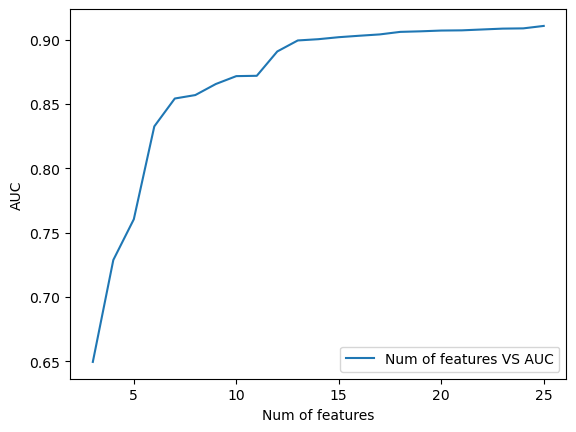

In [36]:
X = [r[0] for r in results_150]
Y = [r[2] for r in results_150]
Metrics.XY_plot([X], [Y], ['Num of features VS AUC'], 'Num of features', 'AUC')

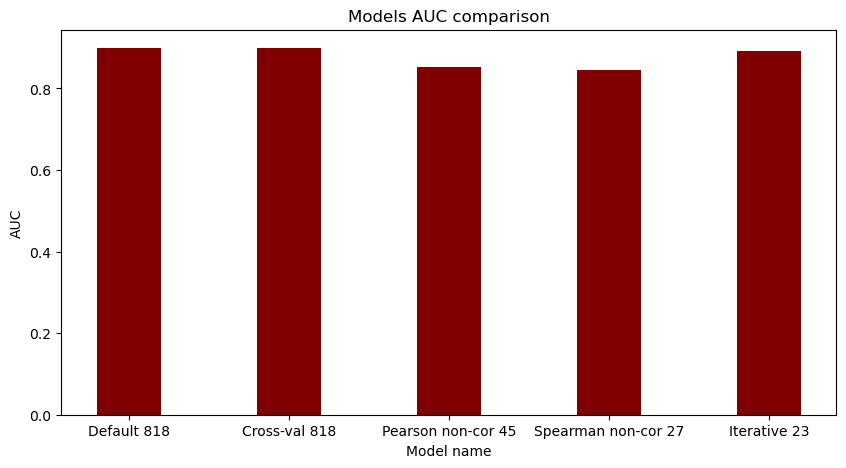

In [37]:
X = [f'Default {df_combine.shape[1]}',
     f'Cross-val {df_combine.shape[1]}',
     f'Pearson non-cor {len(pearson_non_corr)}',
     f'Spearman non-cor {len(spearman_non_corr)}',
     f'Iterative {len(iterativeFeatures)}' ]

Y = [normal.get_test_ROCAUC(),
     enhanced.get_test_ROCAUC(),
     pearson_test_selector.get_test_ROCAUC(),
     spearman_test_selector.get_test_ROCAUC(),
     iterative_150.get_test_ROCAUC() ]

Metrics.BAR_plot(X, Y, 'Models AUC comparison', 'Model name', 'AUC')

In [38]:
iterative_150.get_important_features()

['loc_market_share',
 'lt',
 'Balance_uah',
 'device_days_usage',
 'days_of_end_last_ppm',
 'imei_mean_long_days_usage',
 'day_end_gba',
 'loc_is_obl_center',
 'imei_mean_days_usage',
 'num_act_days_std_mnt3',
 'voice_mts_in_dwork_part_mea_mnt3',
 'imei_mean_day_announced',
 'all_cnt_std_mnt1',
 'myvf_day_usage',
 'content_cnt_mea_mnt3',
 'MV_Traf_Cont_inc_s_Cnt',
 'num_act_days_min_mnt3',
 'count_day_for_last_paym',
 'sms_in_cnt_std_mnt3',
 'all_cnt_std_mnt3',
 'data_3g_tv_cnt_std_mnt3',
 'sum_paym_6_month',
 'num_act_days_mea_mnt1']

## Filling Missing Data
### Selecting iterative model, because it showed best AUC with less num of features

In [39]:
finalFeatures = [*[f for f in iterativeFeatures], *['target', 'ind']]
df_final = df_combine[finalFeatures]

In [40]:
imputed_path = '___final_dataset_knn.pcl'
knn_model_path =  '___kkn_no_skew.pcl'

if os.path.exists(imputed_path) == True:
    df_final = pickle.load(open(imputed_path, 'rb'))
else:
    # kwargs -> col_names_to_impute, verbose, impute_method
    df_final = impute_numeric_cols(df_final, col_names_to_impute = get_empty_cols(df_final), verbose = True, impute_method = 'knn')
    pickle.dump(df_final, open(imputed_path, 'wb'))
    
df_final = remove_skew(df_final, excluded_features = ['target'])
kkn_no_skew = EnhancedLGBMSelector(df_final, knn_model_path)

invalid value encountered in log1p


Skipping column: target


In [41]:
imputed_path = '___final_dataset_randomforest.pcl'
randomforest_model_path = '___randomforest_no_skew.pcl'

if os.path.exists(imputed_path) == True:
    df_final = pickle.load(open(imputed_path, 'rb'))
else:
    # kwargs -> col_names_to_impute, verbose, impute_method
    df_final = impute_numeric_cols(df_final, col_names_to_impute = get_empty_cols(df_final), verbose = True, impute_method = 'randomforest')
    pickle.dump(df_final, open(imputed_path, 'wb'))
    
df_final = remove_skew(df_final, excluded_features = ['target'])
randomforest_no_skew = EnhancedLGBMSelector(df_final, randomforest_model_path)

invalid value encountered in log1p


Skipping column: target


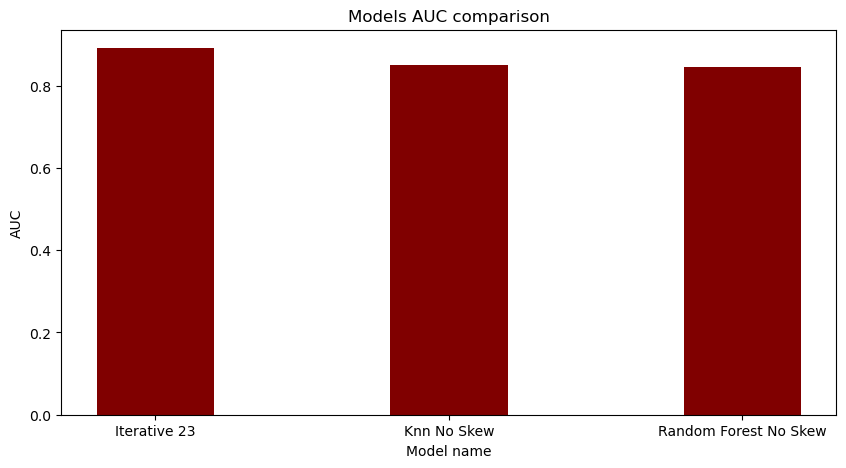

In [42]:
X = [ 'Iterative' + ' ' + str(len(iterativeFeatures)),
      'Knn No Skew',
      'Random Forest No Skew' ]

Y = [ iterative_150.get_test_ROCAUC(), kkn_no_skew.get_test_ROCAUC(), randomforest_no_skew.get_test_ROCAUC() ]
  
Metrics.BAR_plot(X, Y, 'Models AUC comparison', 'Model name', 'AUC')

### Threshold + Metrics

In [43]:
# model selection
best_model = normal

In [242]:
# https://datascience.stackexchange.com/questions/96690/how-to-choose-the-right-threshold-for-binary-classification
# https://machinelearningmastery.com/probability-metrics-for-imbalanced-classification/
# https://ploomber.io/blog/threshold/

Metrics.plot_auc([best_model.y_train, best_model.y_test], [best_model.train_predicted,  best_model.test_predicted], ['train', 'test'])

NameError: name 'best_model' is not defined

In [89]:
f1_selector = F1ThresholdSelector()
f1_threshold = f1_selector.get_threshold(best_model.y_train, best_model.train_predicted)
print(f'F1 based threshold: {f1_threshold}')

NameError: name 'best_model' is not defined

In [90]:
price_based_selector = PriceBasedThresholdSelector(1000, 50, True)
price_based_thr = price_based_selector.get_threshold(best_model.y_train, best_model.train_predicted)
print(f'Price based threshold: {price_based_thr}')

NameError: name 'best_model' is not defined

In [91]:
f1_price = f1_selector.price_for_threshold(round(f1_threshold, 2))
price_based = price_based_selector.price_for_threshold(round(price_based_thr, 2))
print(f'f1 price: {f1_price}. Price based: {price_based}. Diff: {f1_price - price_based}')

AttributeError: 'F1ThresholdSelector' object has no attribute 'price_for_threshold'

In [92]:
with_f1_threshold = ThresholdHelper.apply_binary_threshold(f1_threshold, best_model.train_predicted)
ConfusionMatrixDisplay.from_predictions(best_model.y_train, with_f1_threshold)

NameError: name 'best_model' is not defined

In [93]:
with_price_threshold = ThresholdHelper.apply_binary_threshold(price_based_thr, best_model.train_predicted)
ConfusionMatrixDisplay.from_predictions(best_model.y_train, with_price_threshold)

NameError: name 'best_model' is not defined

In [94]:
print(Metrics.classification_report(best_model.y_train, with_f1_threshold))

NameError: name 'best_model' is not defined

In [95]:
print(Metrics.classification_report(best_model.y_train, with_price_threshold))

NameError: name 'best_model' is not defined

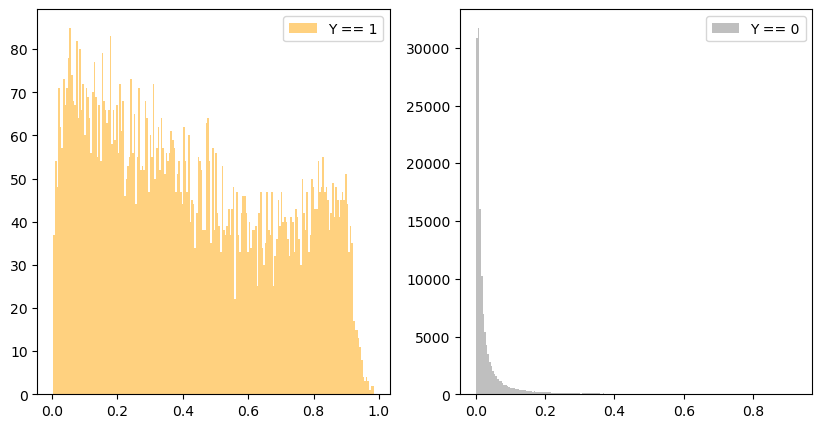

In [52]:
Metrics.plot_probability_distribution(best_model.y_train, best_model.train_predicted)

### Check if dataset is balanced

In [ ]:
churned = round(len(df_combine[df_combine['target'] == 1])/len(df_combine)*100,2)
not_churned = round(len(df_combine[df_combine['target'] == 0])/len(df_combine)*100,2)

In [ ]:
y = [churned, not_churned]
x = [f'Churned {churned}%', f'Not churned {not_churned}%']
Metrics.BAR_plot(x, y, 'If dataset balanced', 'Churbed/Not churned', 'Percentage', 5, 5)

## Feature engineering
#### Check inbound calls from non-vodaphone number in min
#### Check outbound calls to non-vodaphone number in min
#### SMS from non-vodaphone number count
#### SMS to non-vodaphone number count
#### Calls to pawnshop, micro credit organizations in mins
#### Calls from pawnshop, micro credit organizations in mins

## Telephones features

In [55]:
churned = df_combine[df_combine['target'] == 1]
churned_with_nums = pd.merge(churned, df_combine_num, on='abon_id', how='left')
churned_numbers = list(churned_with_nums['bnum'].unique())

non_churned = df_combine[df_combine['target'] == 0]
non_churned_with_nums = pd.merge(non_churned, df_combine_num, on='abon_id', how='left')
non_churned_numbers = list(non_churned_with_nums['bnum'].unique())

In [56]:
churn_number_abon_had_communicated = (set(churned_numbers) - set(non_churned_numbers))
df_churn_abon_had_communicated = pd.DataFrame(churn_number_abon_had_communicated, columns= ['bnum'])
churned_df = churned_with_nums[churned_with_nums['bnum'].isin(list(churn_number_abon_had_communicated))]

In [57]:
non_churn_number_abon_had_communicated = set(non_churned_numbers) - set(churned_numbers)
df_non_churn_abon_had_communicated = pd.DataFrame(non_churn_number_abon_had_communicated, columns= ['bnum'])
non_churned_df = non_churned_with_nums[non_churned_with_nums['bnum'].isin(list(non_churn_number_abon_had_communicated))]

In [58]:
short_nums = [t for t in churn_number_abon_had_communicated if TelephoneHelper.is_short_number(t) or TelephoneHelper.is_string_number(t)]
print(f'Numbers churned abonents communicated with: {short_nums}')

Numbers churned abonents communicated with: [b'mxsms', b'hexcarbon', b'5454', b'lombgotivka', b'diamarket', b'torross', b'test', b'correos', b'pudra.stor', b'tvoyapozyk', b'ecotrade', b'change', b'1107', b'fczenit', b'5515', b'awt dnepr', b'palchikova', b'internetma', b'dobroludya', b'7001', b'5170', b'whitecredi', b'meganomer', b'clinica mc', b'solar', b'brook clean', b'support.vo', b'biotestlab', b'707', b'clinic mss', b'sumuiu', b'7300', b'foodera', b'6218', b'tehnotop', b'0578', b'3600', b'430', b'mobihel', b'shopintriga', b'uaswitch', b'9444', b'3113', b'domoscope', b'maxdudka', b'lino home', b'erudito', b'inbox.eu', b'zakupkipro', b'9405', b'mayak-medoc', b'timeshop', b'foxdental', b'ledproector', b'usavitamin', b'affiliate', b'lombard zf', b'vsezaimy', b'autogranit', b'gett', b'4908', b'2552', b'5135', b'avtoznak', b'tviybarber', b'7500', b'dobroludyam', b'if-toys.com', b'eka clinic', b'8313', b'moto', b'admiralinfo', b'5281', b'trade admin', b'money_point', b'3103', b'onverify'

In [59]:
short_nums = [t for t in non_churn_number_abon_had_communicated if TelephoneHelper.is_short_number(t) or TelephoneHelper.is_string_number(t)]
print(f'Numbers non-churned abonents communicated with: {short_nums}')

Numbers non-churned abonents communicated with: [b'trimmersho', b'rozy_opt', b'leroy', b'1045', b'teplomarke', b'hots.com.ua', b'unit store', b'fonarevka', b'pershavoda', b'cash4u', b'prybambasy', b'yoola', b'topy', b'goodnews', b'tbmarketing', b'png.print', b'joint', b'terapiaplus', b'suzuki kh', b'delicia', b'kvartgrupp', b'panorama', b'kolomiec', b'elaliza_ua', b'linkoln ar', b'futbolkin', b'grandtexti', b'multicom', b'profiprot', b'formuladen', b'monlik', b'dinners', b'halom', b'cukiernia', b'watch.ua', b'sady pobedy', b'mycom', b'pizza-bar', b'mr.lens', b'icn', b'zonagirl', b'chas-to', b'nim-net', b'supersale', b'mensstores', b'553', b'esteva', b'animal-id', b'bipauto', b'top tovar', b'starpizza', b'vizerunok', b'braunmarket', b'galantereya', b'bukovel', b'askida gol', b'mhp_ke', b't2tv.com.u', b'ford_niko', b'sneakermat', b'5400', b'chatanddat', b'cto omega', b'mypvbki', b'raskraska', b'sumki-dina', b'climat-opt', b'favorit cr', b'moryaktaxl', b'pravdaua', b'tdp.com.ua', b'ava ma

In [60]:
class TelephoneFeatureAdder:
    
    save_enhanced_telephone_path = '___save_enhanced_telephone_path.pkl'
    __PAWNSHOPS__ = [b'lombard zf', b'money_point', b'whitecredi', b'vsezaimy', b'tvoyapozyk']
    
    def __init__(self, df_combine, df_combine_num):
        self.df_combine = df_combine
        self.df_combine_num = df_combine_num
        self.call_dur_in_mask = (self.df_combine_num['call_dur_in'] > 0)
        self.call_dur_out_mask = (self.df_combine_num['call_dur_out'] > 0)
        self.sms_cnt_in_mask = (self.df_combine_num['cnt_sms_in'] > 0) 
        self.sms_cnt_out_mask = (self.df_combine_num['cnt_sms_out'] > 0) 
        self.non_vodafone_num_mask = (self.df_combine_num['bnum'].apply(TelephoneHelper.is_non_vodafone))
        self.kyivstar_num_mask = (self.df_combine_num['bnum'].apply(TelephoneHelper.is_kyivstar))
        self.life_num_mask = (self.df_combine_num['bnum'].apply(TelephoneHelper.is_life))
        self.pawnshop_num_mask = (self.df_combine_num['bnum'].isin(self.__PAWNSHOPS__))

    def get_incoming_non_vodafone_nums(self, abon_id):
        data = self.df_combine_num[(self.df_combine_num['abon_id'] == abon_id) & (self.call_dur_in_mask) & (self.non_vodafone_num_mask)]
        res = data['call_dur_in'].sum();
        del data
        return res

    def get_outgoing_non_vodafone_nums(self, abon_id):
        data = self.df_combine_num[(self.df_combine_num['abon_id'] == abon_id) & (self.call_dur_out_mask) & (self.non_vodafone_num_mask)]
        res = data['call_dur_out'].sum()
        del data
        return res
    
    def get_outgoing_kyivstar_nums(self, abon_id):
        data = self.df_combine_num[(self.df_combine_num['abon_id'] == abon_id) & (self.call_dur_out_mask) & (self.kyivstar_num_mask)]
        res = data['call_dur_out'].sum()
        del data
        return res
    
    def get_incoming_kyivstar_nums(self, abon_id):
        data = self.df_combine_num[(self.df_combine_num['abon_id'] == abon_id) & (self.call_dur_in_mask) & (self.kyivstar_num_mask)]
        res = data['call_dur_in'].sum()
        del data
        return res
    
    def get_outgoing_life_nums(self, abon_id):
        data = self.df_combine_num[(self.df_combine_num['abon_id'] == abon_id) & (self.call_dur_out_mask) & (self.life_num_mask)]
        return data['call_dur_out'].sum()
    
    def get_incoming_life_nums(self, abon_id):
        data = self.df_combine_num[(self.df_combine_num['abon_id'] == abon_id) & (self.call_dur_in_mask) & (self.life_num_mask)]
        res = data['call_dur_in'].sum()
        del data
        return res
    
    def get_incoming_non_vodafone_sms_nums(self, abon_id):
        data = self.df_combine_num[(self.df_combine_num['abon_id'] == abon_id) &  (self.sms_cnt_in_mask) & (self.non_vodafone_num_mask)]
        res = data['cnt_sms_in'].sum()
        del data
        return res

    def get_outgoing_non_vodafone_sms_nums(self, abon_id):    
        data = self.df_combine_num[(self.df_combine_num['abon_id'] == abon_id) & (self.sms_cnt_out_mask) & (self.non_vodafone_num_mask)]
        res = data['cnt_sms_out'].sum()
        del data
        return res

    def get_incoming_pawnshops_sms_nums(self, abon_id):
        data = self.df_combine_num[(self.df_combine_num['abon_id'] == abon_id) & (self.sms_cnt_in_mask) & (self.pawnshop_num_mask)]
        res = data['cnt_sms_in'].sum()
        del data
        return res

    def add_incoming_non_vodaphone(self):
        self.df_combine['incoming_call_non_vodafone'] = self.df_combine['abon_id'].parallel_apply(self.get_incoming_non_vodafone_nums)
        print('incoming_call_non_vodafone done')
        pickle.dump(self.df_combine, open(self.save_enhanced_telephone_path, 'wb'))
        
    def add_outgoing_non_vodaphone(self):
        self.df_combine['outgoing_call_non_vodafone'] = self.df_combine['abon_id'].parallel_apply(self.get_outgoing_non_vodafone_nums)
        print('outgoing_call_non_vodafone done')
        pickle.dump(self.df_combine, open(self.save_enhanced_telephone_path, 'wb'))
        
    def add_incoming_sms_non_vodafone(self):
        self.df_combine['incoming_sms_non_vodafone'] = self.df_combine['abon_id'].parallel_apply(self.get_incoming_non_vodafone_sms_nums)
        print('incoming_sms_non_vodafone done')
        pickle.dump(self.df_combine, open(self.save_enhanced_telephone_path, 'wb'))
        
    def add_outgoing_sms_non_vodafone(self):
        self.df_combine['outgoing_sms_non_vodafone'] = self.df_combine['abon_id'].parallel_apply(self.get_outgoing_non_vodafone_sms_nums)
        print('outgoing_sms_non_vodafone done')
        pickle.dump(self.df_combine, open(self.save_enhanced_telephone_path, 'wb'))
        
    def add_incoming_sms_pawnshop(self):
        self.df_combine['incoming_sms_pawnshop'] = self.df_combine['abon_id'].parallel_apply(self.get_incoming_pawnshops_sms_nums)
        print('incoming_sms_pawnshop done')        
        pickle.dump(self.df_combine, open(self.save_enhanced_telephone_path, 'wb'))
        
    def add_outgoing_call_kyivstar(self):
        self.df_combine['outgoing_call_kyivstar'] = self.df_combine['abon_id'].parallel_apply(self.get_outgoing_kyivstar_nums)
        print('outgoing_call_kyivstar done')
        pickle.dump(self.df_combine, open(self.save_enhanced_telephone_path, 'wb'))
        
    def add_incoming_call_kyivstar(self):
        self.df_combine['incoming_call_kyivstar'] = self.df_combine['abon_id'].parallel_apply(self.get_incoming_kyivstar_nums)
        print('incoming_call_kyivstar done')
        pickle.dump(self.df_combine, open(self.save_enhanced_telephone_path, 'wb'))
        
    def add_outgoing_call_life(self):
        self.df_combine['outgoing_call_life'] = self.df_combine['abon_id'].parallel_apply(self.get_outgoing_life_nums)
        print('outgoing_call_life done')
        pickle.dump(self.df_combine, open(self.save_enhanced_telephone_path, 'wb'))
        
    def add_incoming_call_life(self):
        self.df_combine['incoming_call_life'] = self.df_combine['abon_id'].parallel_apply(self.get_incoming_life_nums)
        print('incoming_call_life done')
        pickle.dump(self.df_combine, open(self.save_enhanced_telephone_path, 'wb'))
    
    def add(self):
        self.add_incoming_non_vodaphone()
        self.add_outgoing_non_vodaphone()
        self.add_outgoing_sms_non_vodafone()
        self.add_incoming_sms_pawnshop()
        self.add_outgoing_call_kyivstar()
        self.add_incoming_call_kyivstar()
        self.add_outgoing_call_life()
        self.add_incoming_call_life()
    
    def save(self):
        if os.path.exists(self.save_enhanced_telephone_path) == False:
            pickle.dump(self.df_combine, open(self.save_enhanced_telephone_path, 'wb'))

In [61]:
if os.path.exists('___save_enhanced_telephone_path.pkl') == False:
    df_combine = df_combine.reset_index(drop=True)
    adder = TelephoneFeatureAdder(df_combine, df_combine_num)
    adder.add()
    adder.save()

df_combine_enriched_tel = pickle.load(open('___save_enhanced_telephone_path.pkl', 'rb'))

In [62]:
enriched_tel_selector = LGBMSelector(df_combine_enriched_tel, -1, None, '___LGBMEnriched_tel.pcl')
enriched_tel_enhanced_selector = EnhancedLGBMSelector(df_combine_enriched_tel, '___EnhancedLGBMSelector_tel.plc')

Trying to unpickle estimator LabelEncoder from version 1.2.2 when using version 1.2.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations


In [63]:
normal.get_test_ROCAUC(), enriched_tel_selector.get_test_ROCAUC(), enriched_tel_enhanced_selector.get_test_ROCAUC()

(0.8980686013446386, 0.8976961074054888, 0.8991201113134197)

In [64]:
normal.get_train_ROCAUC(), enriched_tel_selector.get_train_ROCAUC(), enriched_tel_enhanced_selector.get_train_ROCAUC()

(0.954024923900115, 0.9532984694056235, 0.9519061658984758)

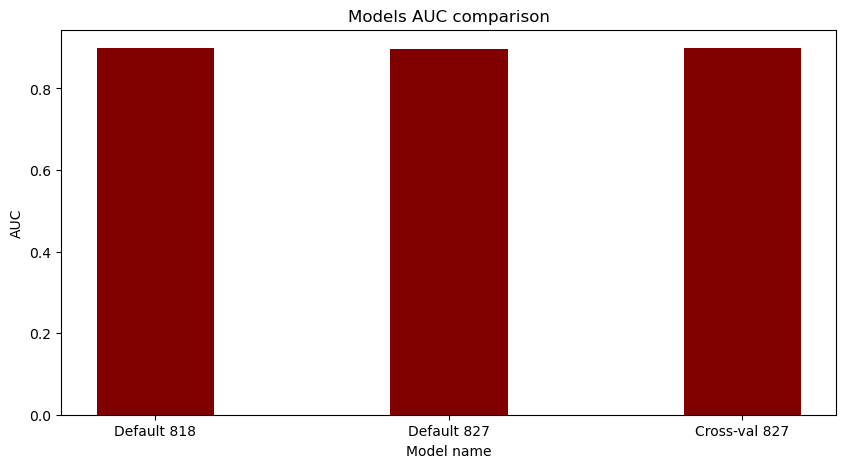

In [65]:
X = [f'Default {df_combine.shape[1]}',
     f'Default {df_combine_enriched_tel.shape[1]}',
     f'Cross-val {df_combine_enriched_tel.shape[1]}' ]

Y = [normal.get_test_ROCAUC(),
     enriched_tel_selector.get_test_ROCAUC(),
     enriched_tel_enhanced_selector.get_test_ROCAUC() ]

Metrics.BAR_plot(X, Y, 'Models AUC comparison', 'Model name', 'AUC')

## Application Features
### Create 4 features for each application sum of duration, sum of volume, sum of events, day of usage

In [66]:
df_combine = df_combine_enriched_tel

In [193]:
def free_memory():

    if 'train_df' in locals(): del train_df
    if 'train_num' in locals(): del train_num
    if 'train_dpi' in locals(): del train_dpi
    if 'test_df' in locals(): del test_df
    if 'test_num' in locals(): del test_num
    if 'test_dpi' in locals():  del test_dpi
    if 'df_combine_num' in locals(): del df_combine_num
    if 'df_combine_dpi' in locals(): del df_combine_dpi

In [194]:
free_memory()

In [80]:
def get_sum_duration(a:int) -> str:
    return f'App_{a}_Sum_Duration'

def get_sum_volume(a:int) -> str:
    return f'App_{a}_Sum_Volume'

def get_count_events(a:int) -> str:
    return f'App_{a}_Count_Events'

def get_app_day_using(a:int) -> str:
    return f'App_{a}_Day_using'

In [70]:
def extend_schema(df_combine):
        
    for a in self.app_ids:

        df_combine.loc[:, get_sum_duration(a)] = 0
        df_combine[self.get_sum_duration(a)].astype('float16')

        df_combine.loc[:, self.get_sum_volume(a)] = 0
        df_combine[self.get_sum_volume(a)].astype('float16')

        df_combine.loc[:, self.get_count_events(a)] = 0
        df_combine[self.get_count_events(a)].astype('float16')

        df_combine.loc[:, self.get_app_day_using(a)] = 0
        df_combine[self.get_app_day_using(a)].astype('float16')

    df_combine = reduce_mem_usage(self.df_combine)
    pickle.dump(df_combine, open('___ALL_mem_reduced.pcl', 'wb'))
        

In [71]:
def do_work(abons, _from, _to, _id):

    print(f'Starting thread {_id} from: {_from} to {_to}. Total: {len(abons)}')
    iterations = 0

    for abon_id in abons[_from : _to]:

        # for every abon get application usage
        df_apps = __DPI__[__DPI__.index == abon_id]
        
        # iterate over each application
        # 0 - app id, 1 - duration, 2 - volume, 3 - count, 4 - max
        for index, row in df_apps.iterrows():           
            
            # get row index for main table for a given app           
            app_id = int(row[0])
            __DF__.loc[abon_id, get_sum_duration(app_id)] = row[1]
            __DF__.loc[abon_id, get_sum_volume(app_id)] = row[2]
            __DF__.loc[abon_id, get_count_events(app_id)] = row[3]
            __DF__.loc[abon_id, get_app_day_using(app_id)] = row[4]

        del df_apps

        iterations+=1

        if (iterations % 100 == 0):
            print(f'Thread {_id}: Iterations: {iterations} Progress: {iterations/len(abons)}')

    print(f'Thread {_id}: Processing ends')

In [27]:
if os.path.exists('___!!!__ALL_save_enhanced_with_apps.pcl') == False:
    
    __DF__ = df_combine
    __DPI__ = df_combine_dpi
    
    __DF__['abon_id'] = __DF__['abon_id'].astype('int')
    __DPI__['abon_id'] = __DPI__['abon_id'].astype('int')
    
    __DF__ = __DF__.set_index(['abon_id'])
    __DPI__ = __DPI__.set_index(['abon_id'])
    abons = list(__DF__.index.unique())
    
    do_work(abons, 0, len(abons), 'thread_1')
    pickle.dump(__DF__, open('___!!!__ALL_save_enhanced_with_apps.pcl', 'wb'))
    
    del __DF__
    del __DPI__
    
df_combine = pickle.load(open('___!!!__ALL_save_enhanced_with_apps.pcl', 'rb'))
df_combine = df_combine.reset_index()

### Building model on extended dataset and select features

In [28]:
print(f'Extended dataset size: {df_combine.shape}')

Extended dataset size: (300000, 3931)


In [29]:
normal = LGBMSelector(df_combine, -1, None, '___ALL_LGBMSelector.pcl')
enhanced = EnhancedLGBMSelector(df_combine, '___ALL_EnhancedLGBMSelector.pcl')

Trying to unpickle estimator LabelEncoder from version 1.2.2 when using version 1.2.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations


In [30]:
normal.get_test_ROCAUC(), enhanced.get_test_ROCAUC()

(0.8987030708510946, 0.9006674471859164)

In [31]:
features = enhanced.get_important_features_tuples()

In [32]:
app_features = [f for f in features if ('App_' in f[0] and f[2] < 100)]

In [33]:
tel_features = [f for f in features if (('incoming' in f[0] or 'outgoing' in f[0]) and f[2] < 100)]

In [34]:
total_features = [ *iterative_150.get_important_features(), *[f[0] for f in app_features], *[f[0] for f in tel_features] ]

NameError: name 'iterative_150' is not defined

In [ ]:
len(total_features)

### Building model on reduced dataset

In [ ]:
df_combine = pickle.load(open('___!!!__ALL_save_enhanced_with_apps.pcl', 'rb'))
df_combine = df_combine.reset_index()
df_combine = df_combine[[*total_features, 'ind', 'target']]

In [ ]:
normal = LGBMSelector(df_combine, -1, None, '___REDUCED_LGBMSelector.pcl')
enhanced = EnhancedLGBMSelector(df_combine, '___REDUCED_EnhancedLGBMSelector.pcl')

In [ ]:
normal.get_test_ROCAUC(), enhanced.get_test_ROCAUC()

### Tune model with optuna

In [107]:
__DF__ = df_combine

In [ ]:
# https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/005_visualization.html

In [ ]:
def objective(trial):
     
    params = {
        'boosting_type' : 'dart',
        'objective': 'binary',
        'is_unbalance' : True,
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-6, 1e-2),
        'metric': 'auc',
        'lambda_l1': trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        'num_leaves': trial.suggest_int("num_leaves", 5, 300),
        'feature_fraction': trial.suggest_float("feature_fraction", 0.2, 1.0),
        'bagging_fraction': trial.suggest_float("bagging_fraction", 0.2, 1.0),
        'bagging_freq': trial.suggest_int("bagging_freq", 1, 7),
        'min_child_samples': trial.suggest_int("min_child_samples", 5, 100),
    }
    
    test, train = split_test_train(__DF__)
    y_train = train['target'].round(0).astype(int)
    y_test = test['target'].round(0).astype(int)
    x_train = train.drop(['target'], axis=1)
    x_test = test.drop(['target'], axis=1)

    # split train on train and validation
    X_train_final, X_test_validation, y_train_final, y_test_validation = train_test_split(x_train, 
                                                                                          y_train, 
                                                                                          stratify=y_train,
                                                                                          test_size=0.25)

    # create datasets
    d_train = lg.Dataset(X_train_final, label=y_train_final)
    d_test = lg.Dataset(X_test_validation, label=y_test_validation, reference=d_train)
    
    
    # Train model
    model = lg.train(params, d_train, valid_sets=d_test)
    
    # Return accuracy on validation set
    return model.best_score['valid_0']['auc']

def optimize():
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=500)
    print([s for s in study.get_trials() if s.value > 0.90])

In [ ]:
best_params = {
    'learning_rate': 0.00707107365722751,
    'lambda_l1': 8.46864849528894e-07,
    'lambda_l2': 6.160785148258716e-07, 
    'num_leaves': 259,
    'feature_fraction': 0.7617036350260967,
    'bagging_fraction': 0.9442852705373347,
    'bagging_freq': 3,
    'min_child_samples': 28 }

In [ ]:
df_combine = df_combine[[*total_features, 'ind', 'target']]

In [ ]:
normal = LGBMSelector(df_combine, -1, best_params, '___REDUCED_OPTIMIZED_LGBMSelector_2.pcl')

In [ ]:
normal.get_train_ROCAUC(), normal.get_test_ROCAUC()

### Metrics

In [134]:
# https://www.kaggle.com/code/cast42/lightgbm-model-explained-by-shap
# https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/Census%20income%20classification%20with%20LightGBM.html
# https://habr.com/ru/companies/ods/articles/599573/#4.2

# https://colab.research.google.com/drive/198er-jzMcE_Sp1VtDSNYuFmu_ob70peH?usp=sharing#scrollTo=1d69898a-db12-43ef-9ec1-4a363ecedf5a
# https://habr.com/ru/articles/428213/

In [135]:
total_features = ['loc_market_share', 'lt', 'Balance_uah', 'device_days_usage',
       'days_of_end_last_ppm', 'imei_mean_long_days_usage', 'day_end_gba',
       'loc_is_obl_center', 'imei_mean_days_usage', 'num_act_days_std_mnt3',
       'voice_mts_in_dwork_part_mea_mnt3', 'imei_mean_day_announced',
       'all_cnt_std_mnt1', 'myvf_day_usage', 'content_cnt_mea_mnt3',
       'MV_Traf_Cont_inc_s_Cnt', 'num_act_days_min_mnt3',
       'count_day_for_last_paym', 'sms_in_cnt_std_mnt3', 'all_cnt_std_mnt3',
       'data_3g_tv_cnt_std_mnt3', 'sum_paym_6_month', 'num_act_days_mea_mnt1',
       'App_678_Count_Events', 'App_258_Sum_Volume', 'App_588_Count_Events',
       'App_909_Count_Events', 'App_598_Sum_Volume', 'App_677_Count_Events',
       'App_897_Sum_Volume', 'App_240_Day_using', 'App_882_Count_Events' ]

In [136]:
len(total_features)

32

In [137]:
feature_to_descr =  { 'device_days_usage':'Number of days device is used',
    'loc_market_share':'Local market share',
    'voice_mts_in_dwork_part_mea_mnt3': 'MEAN number of calls inside network for last 3 month',
    'lt':'Abonent life time',
    'days_of_end_last_ppm':'Number of days after ending the last monthly package service',
    'sum_paym_6_month':'Sum of replenishment for last 6 month',
    'sms_in_cnt_std_mnt3':'STD Number of incoming sms for last 3 month',
    'all_cnt_std_mnt1':'STD General number of events count for 1 month',
    'num_act_days_mea_mnt1': 'MEAN number of active days usage of vodafone services',
    'imei_mean_day_announced':'MEAN date of IMEI being annonced',
    'Balance_uah':'Balance UAH',
    'imei_mean_days_usage':'MEAN days of device usage',
    'count_day_for_last_paym':'Number of days from the last replenishment',
    'MV_Traf_Cont_inc_s_Cnt':'Incoming SMS count',
    'data_3g_tv_cnt_std_mnt3':'STD number of 3G connections',
    'content_cnt_mea_mnt3':'Number of events for content using',
    'imei_mean_long_days_usage': 'MEAN duration of device using',
    'App_240_Day_using':'APP 240 days of using',
    'all_cnt_std_mnt3': 'STD general number of events for last 3 month',
    'myvf_day_usage':'Number of days using  My Vodafone',
    'App_258_Sum_Volume':'APP 258 sum of traffic',
    'App_677_Count_Events':'APP 677 number of events',
    'App_897_Sum_Volume': 'APP 897 sum of traffic',
    'App_678_Count_Events':'APP 678 number of events',
    'App_882_Count_Events':'APP 882 number of events',
    'num_act_days_min_mnt3':'MIN number of days using services for last 3 month',
    'num_act_days_std_mnt3':'STD number of days using services for last 3 month',
    'day_end_gba':'Date of abonent expiration',
    'App_598_Sum_Volume':'APP 598 sum of traffic',
    'App_588_Count_Events':'APP 588 number of events',
    'loc_is_obl_center':'Number of events in the region center',
    'App_909_Count_Events':'APP 909 number of events' }


In [138]:
names = []

for f in total_features:
    descr = feature_to_descr[f]
    names.append(descr)

In [139]:
df_combine = pickle.load(open('___REDUCED_FINAL_DS.pcl', 'rb'))
df_combine = df_combine[[*total_features, 'ind', 'target']]

In [140]:
enhanced = EnhancedLGBMSelector(df_combine, '___REDUCED_SHAP_EnhancedLGBMSelector.pcl')

In [141]:
enhanced.get_train_ROCAUC(), enhanced.get_test_ROCAUC()

(0.9399605490931914, 0.8936959439179637)

In [142]:
enhanced.get_important_features_tuples()

[('device_days_usage', 876, 0),
 ('loc_market_share', 819, 1),
 ('voice_mts_in_dwork_part_mea_mnt3', 641, 2),
 ('lt', 599, 3),
 ('days_of_end_last_ppm', 558, 4),
 ('sum_paym_6_month', 540, 5),
 ('sms_in_cnt_std_mnt3', 447, 6),
 ('all_cnt_std_mnt1', 440, 7),
 ('num_act_days_mea_mnt1', 430, 8),
 ('imei_mean_day_announced', 430, 9),
 ('Balance_uah', 416, 10),
 ('imei_mean_days_usage', 401, 11),
 ('count_day_for_last_paym', 386, 12),
 ('MV_Traf_Cont_inc_s_Cnt', 381, 13),
 ('data_3g_tv_cnt_std_mnt3', 370, 14),
 ('content_cnt_mea_mnt3', 357, 15),
 ('imei_mean_long_days_usage', 347, 16),
 ('App_240_Day_using', 301, 17),
 ('all_cnt_std_mnt3', 294, 18),
 ('myvf_day_usage', 292, 19),
 ('App_258_Sum_Volume', 285, 20),
 ('App_677_Count_Events', 275, 21),
 ('App_897_Sum_Volume', 268, 22),
 ('App_678_Count_Events', 263, 23),
 ('App_882_Count_Events', 256, 24),
 ('num_act_days_min_mnt3', 255, 25),
 ('num_act_days_std_mnt3', 238, 26),
 ('day_end_gba', 235, 27),
 ('App_598_Sum_Volume', 215, 28),
 ('App

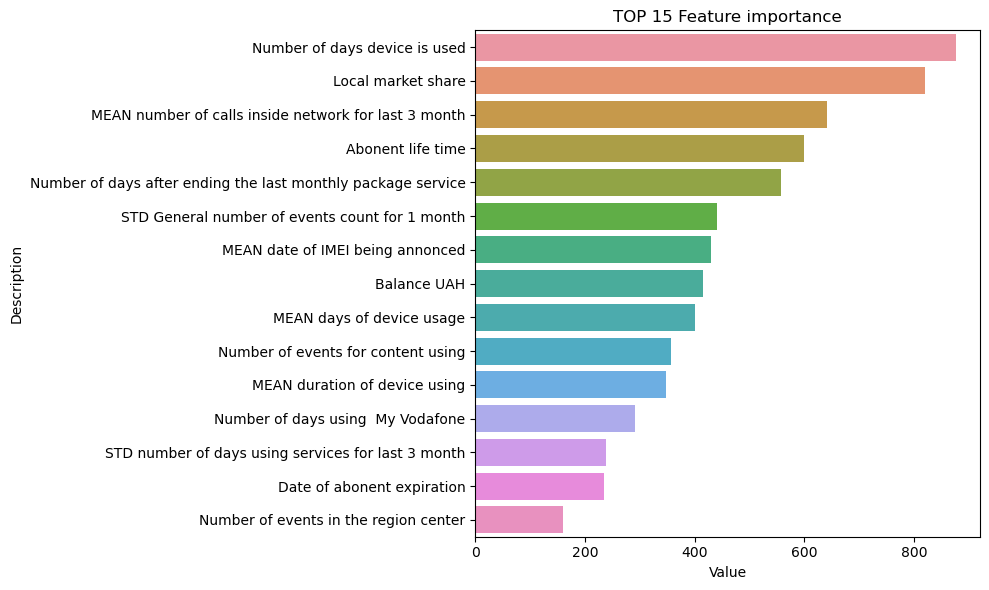

In [143]:
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

feature_imp = pd.DataFrame(sorted(zip(enhanced.regressor.feature_importance()[0:15], total_features)), columns=['Value','Feature'])
feature_imp['Description'] = feature_imp['Feature'].apply(lambda f: feature_to_descr[f])

plt.figure(figsize=(10, 6))
sns.barplot(x="Value", y="Description", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('TOP 15 Feature importance')
plt.tight_layout()
plt.show()

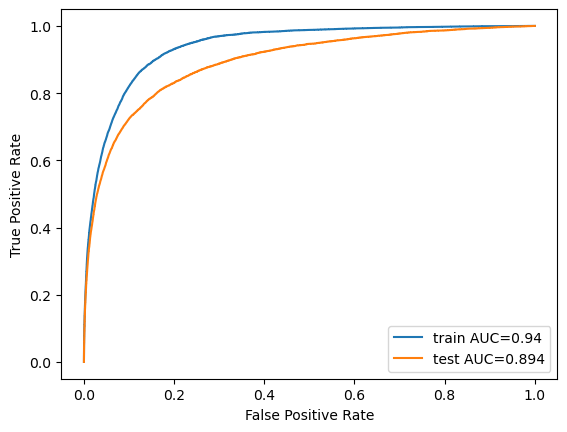

In [144]:
Metrics.plot_auc([enhanced.y_train, enhanced.y_test], [enhanced.train_predicted,  enhanced.test_predicted], ['train', 'test'])

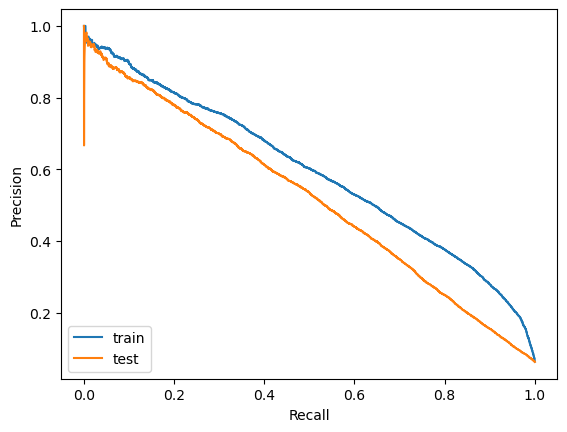

In [145]:
Metrics.plot_precision_recall([enhanced.y_train, enhanced.y_test], [enhanced.train_predicted,  enhanced.test_predicted], ['train', 'test'])

In [163]:
__RETAIN__ = 50
__ADD_NEW__ = 3000

In [164]:
f1_selector = F1ThresholdSelector()
f1_threshold = f1_selector.get_threshold(enhanced.y_train, enhanced.train_predicted)
print(f'F1 based threshold: {f1_threshold}')

F1 based threshold: 0.7696074626292226


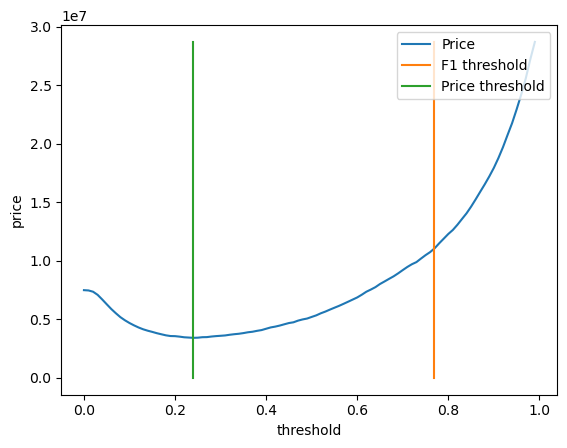

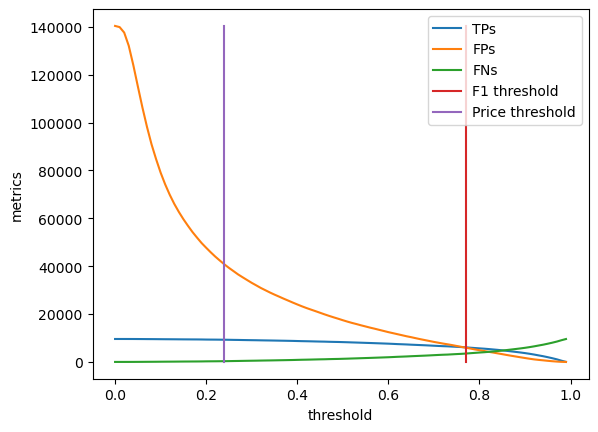

Price based threshold: 0.24


In [165]:
price_based_selector = PriceBasedThresholdSelector(__ADD_NEW__, __RETAIN__, True)
price_based_thr = price_based_selector.get_threshold(enhanced.y_train, enhanced.train_predicted)
print(f'Price based threshold: {price_based_thr}')

In [166]:
f1_price = price_based_selector.price_for_threshold(round(f1_threshold, 2))
price_based = price_based_selector.price_for_threshold(round(price_based_thr, 2))
do_nothing = sum(enhanced.y_train)*__ADD_NEW__
print(f'f1 price: {f1_price}. Price based: {price_based}. Do nothing: {do_nothing}. Diff: {f1_price - price_based}')

f1 price: 11080400. Price based: 3426400. Do nothing: 28758000. Diff: 7654000


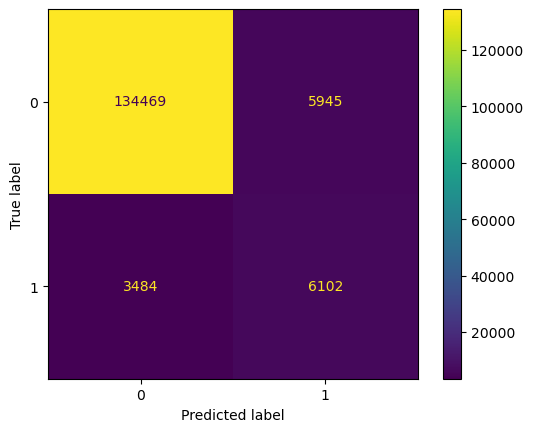

In [167]:
with_f1_threshold = ThresholdHelper.apply_binary_threshold(f1_threshold, enhanced.train_predicted)
ConfusionMatrixDisplay.from_predictions(enhanced.y_train, with_f1_threshold)

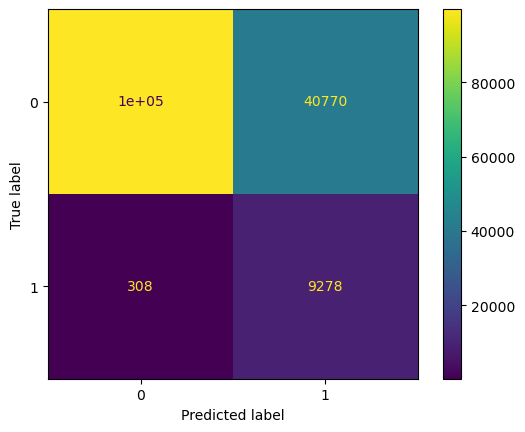

In [168]:
with_price_threshold = ThresholdHelper.apply_binary_threshold(price_based_thr, enhanced.train_predicted)
ConfusionMatrixDisplay.from_predictions(enhanced.y_train, with_price_threshold)

In [169]:
print(Metrics.classification_report(enhanced.y_train, with_f1_threshold))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97    140414
           1       0.51      0.64      0.56      9586

    accuracy                           0.94    150000
   macro avg       0.74      0.80      0.77    150000
weighted avg       0.94      0.94      0.94    150000



In [153]:
print(Metrics.classification_report(enhanced.y_train, with_price_threshold))

              precision    recall  f1-score   support

           0       1.00      0.71      0.83    140414
           1       0.19      0.97      0.31      9586

    accuracy                           0.73    150000
   macro avg       0.59      0.84      0.57    150000
weighted avg       0.95      0.73      0.80    150000



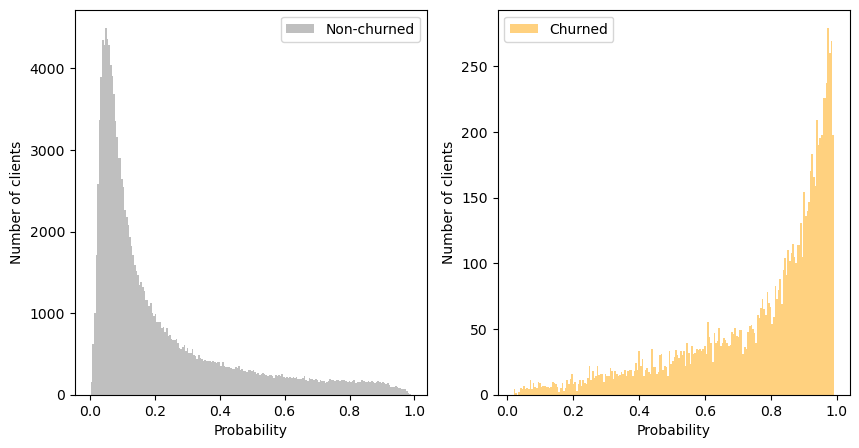

In [162]:
Metrics.plot_probability_distribution(enhanced.y_train, enhanced.train_predicted)

### SHAP

In [155]:
explainer = shap.TreeExplainer(enhanced.regressor)
expected_value = explainer.expected_value
if isinstance(expected_value, list):
    expected_value = expected_value[1]
print(f"Explainer expected value: {expected_value}")

Explainer expected value: [-1.50689109]


In [156]:
train_df, train_num, train_dpi, test_df, test_num, test_dpi = load_churn_reduced()
df_combine, df_combine_num, df_combine_dpi = combine_data(train_df, train_num, train_dpi, test_df, test_num, test_dpi)

In [157]:
len(df_combine_dpi['Application'].unique())

776

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


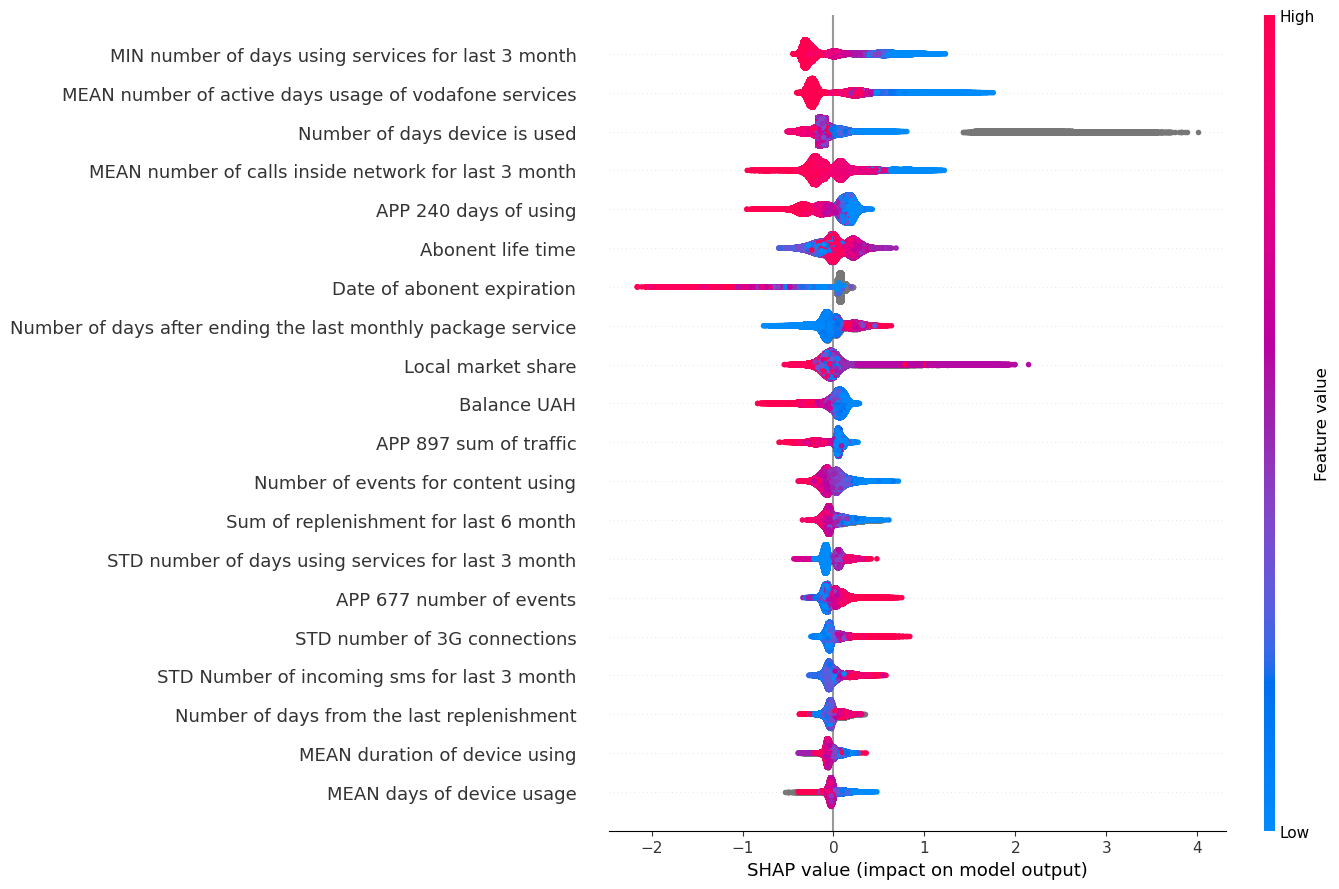

In [131]:
# pickle.dump(shap_values, open('___SHAP.pcl', 'wb'))
# shap_values = explainer.shap_values(df_combine[total_features])

pd.DataFrame(shap_values[1])
shap.summary_plot(shap_values[1], df_combine[total_features], plot_size=(14,9), feature_names = names )

In [41]:
shap_values = shap.TreeExplainer(enhanced.regressor).shap_values(enhanced.x_train)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


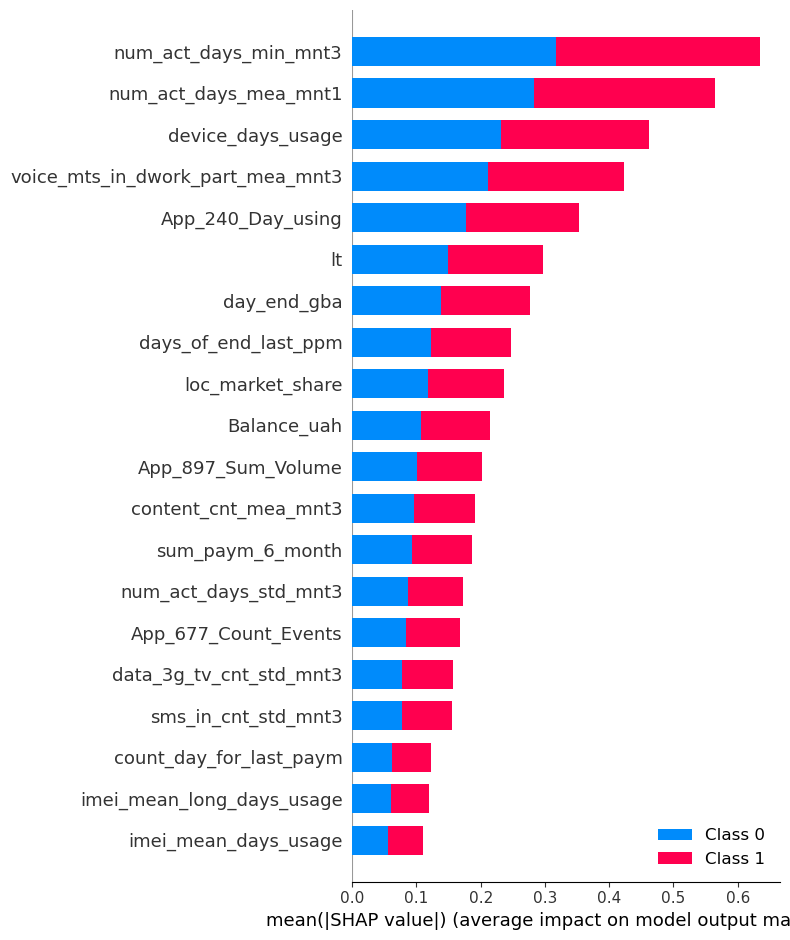

In [46]:
shap.summary_plot(shap_values, enhanced.x_train)

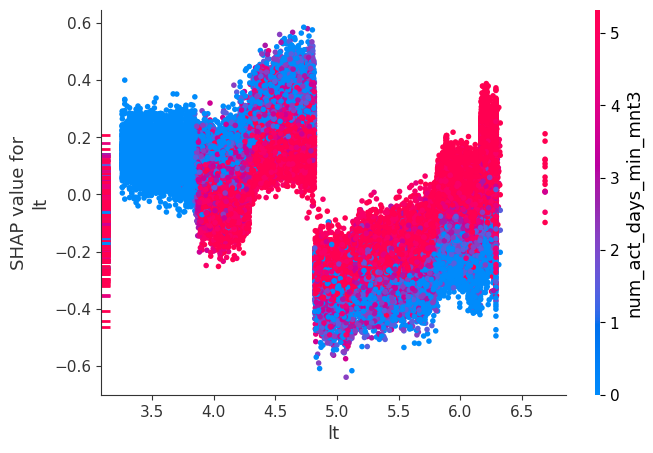

In [54]:
shap.dependence_plot('lt', shap_values[0], enhanced.x_train, interaction_index="num_act_days_min_mnt3")

In [51]:
df_combine.columns

Index(['loc_market_share', 'lt', 'Balance_uah', 'device_days_usage',
       'days_of_end_last_ppm', 'imei_mean_long_days_usage', 'day_end_gba',
       'loc_is_obl_center', 'imei_mean_days_usage', 'num_act_days_std_mnt3',
       'voice_mts_in_dwork_part_mea_mnt3', 'imei_mean_day_announced',
       'all_cnt_std_mnt1', 'myvf_day_usage', 'content_cnt_mea_mnt3',
       'MV_Traf_Cont_inc_s_Cnt', 'num_act_days_min_mnt3',
       'count_day_for_last_paym', 'sms_in_cnt_std_mnt3', 'all_cnt_std_mnt3',
       'data_3g_tv_cnt_std_mnt3', 'sum_paym_6_month', 'num_act_days_mea_mnt1',
       'App_678_Count_Events', 'App_258_Sum_Volume', 'App_588_Count_Events',
       'App_909_Count_Events', 'App_598_Sum_Volume', 'App_677_Count_Events',
       'App_897_Sum_Volume', 'App_240_Day_using', 'App_882_Count_Events',
       'ind', 'target'],
      dtype='object')

In [ ]:
#np.float = float
#
#for name in enhanced.x_train.columns:
#    shap.dependence_plot(name, shap_values[1], enhanced.x_train)